# EEG-ERP Preprocessing – Batch script
## OSL_ERP study

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
from os import remove
from glob import glob
from pathlib import Path
import yaml
from yaml import CLoader as Loader
import mne
mne.set_log_level('error')
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import zscore
from autoreject import Ransac, get_rejection_threshold, AutoReject
from time import time

## Read Parameters from config.yml

Will import study-level parameters from `config.yml` in `bids_root`

In [2]:
# this shouldn't change if you run this script from its default location in code/import
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = {k: v for d in config['eog'] for k, v in d.items()}
drop_ch = config['drop_ch']            
montage_fname = config['montage_fname']
event_id = {k: v.pop() for d in config['events'] for k, v in d.items()}

# fix per changes to config
n_jobs = config['preprocessing_settings']['n_jobs']
filt_p = {k: v for d in config['preprocessing_settings']['filter'] for k, v in d.items()}
ica_p =  {k: v for d in config['preprocessing_settings']['ica'] for k, v in d.items()}
epoch_p =  {k: v for d in config['preprocessing_settings']['epoch'] for k, v in d.items()}

### Paths

In [3]:
raw_path = op.join(bids_root, 'rawdata')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'logs')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)


epochs_suffix = '-epo.fif'

### Subject list

In [4]:
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(raw_path + '/' + prefix + '*')])

## Read manually-marked independent components
Run this script once, inspect ICs, make decisions about whether any additional ICs should be added, or any automatically-removed ICs should be included.

Additional ICs to remove were selected based on:
- participants for whom more than 15% of trials were removred by AutoReject after ICA correct
- participants for whom the average across all trials and all electrodes did not show a clear pattern of P1-N1-P2 components
- for such participants, the scalp map and details of each IC were visuall inspected. Components were removed if they were
    - focal at a single electrode, or a very low number of electrodes
    - focal at the edges of the electrode montage
    - present on a low number of trials
    - showed no systematic pattern across trials that was time-locked to stimulus onset
    
ICs to add (un-remove) were selected based on:
- IC shows clear and consistent temporal dependency on stimulus onset
- IC appears to contain P1-N1-P2 complex, or part thereof
- IC has broad scalp distribution across many electrodes, characteristic of ERP component

In [5]:
cfg_file = op.join(raw_path + '/participants_manual_IC.yml')
with open(cfg_file, 'r') as f:
    ica_manual = yaml.load(f, Loader=Loader)

## Main Loop


-------------------------
-------- sub-001 --------
-------------------------
n_interpolate = 16
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
N

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 16
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  272.96496176719666

-------------------------
-------- sub-004 --------
-------------------------


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 8
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 p

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 64
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  297.7793390750885

-------------------------
-------- sub-007 --------
-------------------------
n_interpolate = 8
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
374 matching events found
No baseline correction applied
0 projection items ac

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  287.10645604133606

-------------------------
-------- sub-011 --------
-------------------------
n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
    Using multitape

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/epochs.py:389: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  this_fig = figure()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/epochs.py:619: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/_mpl_figure.py:2083: RuntimeWarning: More than 20 figures have been opened. Figures c

Total processing time:  938.632908821106

-------------------------
-------- sub-015 --------
-------------------------


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/_mpl_figure.py:2083: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/_mpl_figure.py:2083: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/viz/misc.py:711: R

n_interpolate = 64


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/autoreject/autoreject.py:1307: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, ax = plt.subplots(figsize=(12, 6))


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items ac

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  377.3249349594116

-------------------------
-------- sub-016 --------
-------------------------


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
477 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  2341.2434918880463

-------------------------
-------- sub-017 --------
-------------------------


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 16
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  280.3808681964874

-------------------------
-------- sub-018 --------
-------------------------
n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_interpolate = 16
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  352.0200171470642

-------------------------
-------- sub-025 --------
-------------------------
n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Total processing tim

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 64
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
297 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Total processing time:  292.3224530220032

-------------------------
-------- sub-046 --------
-------------------------


/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/mne/bem.py:1123: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


n_interpolate = 16
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
296 matching events found
No baseline correction applied
0 

/Users/aaron/mambaforge/envs/eeg/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_interpolate = 32
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 

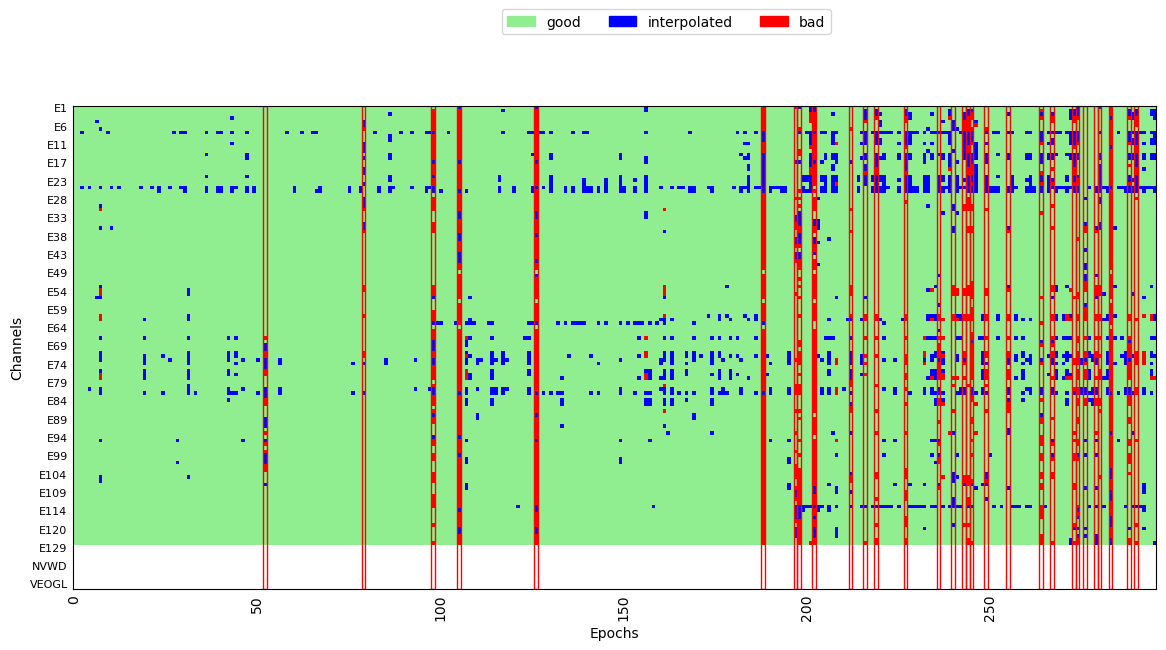

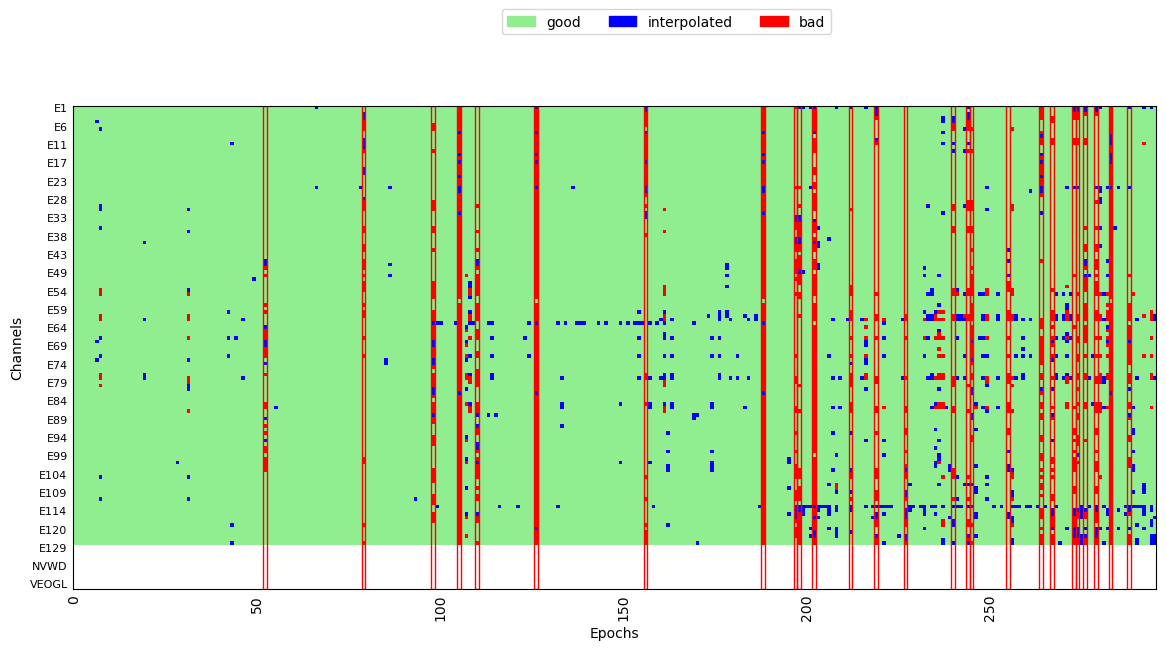

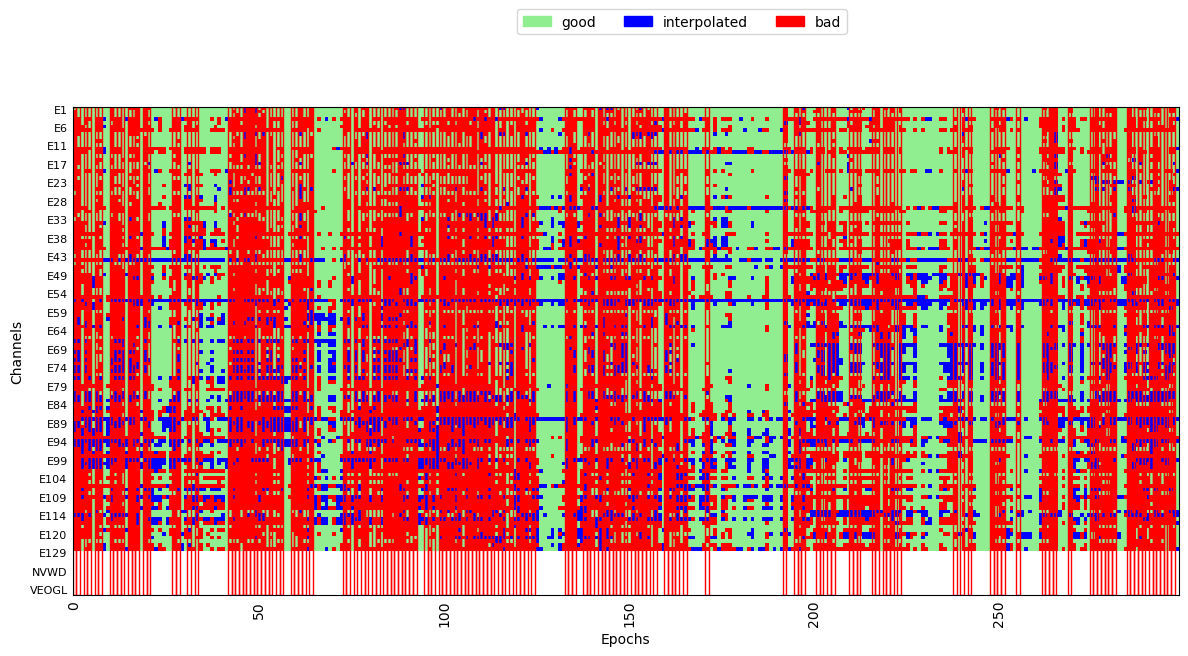

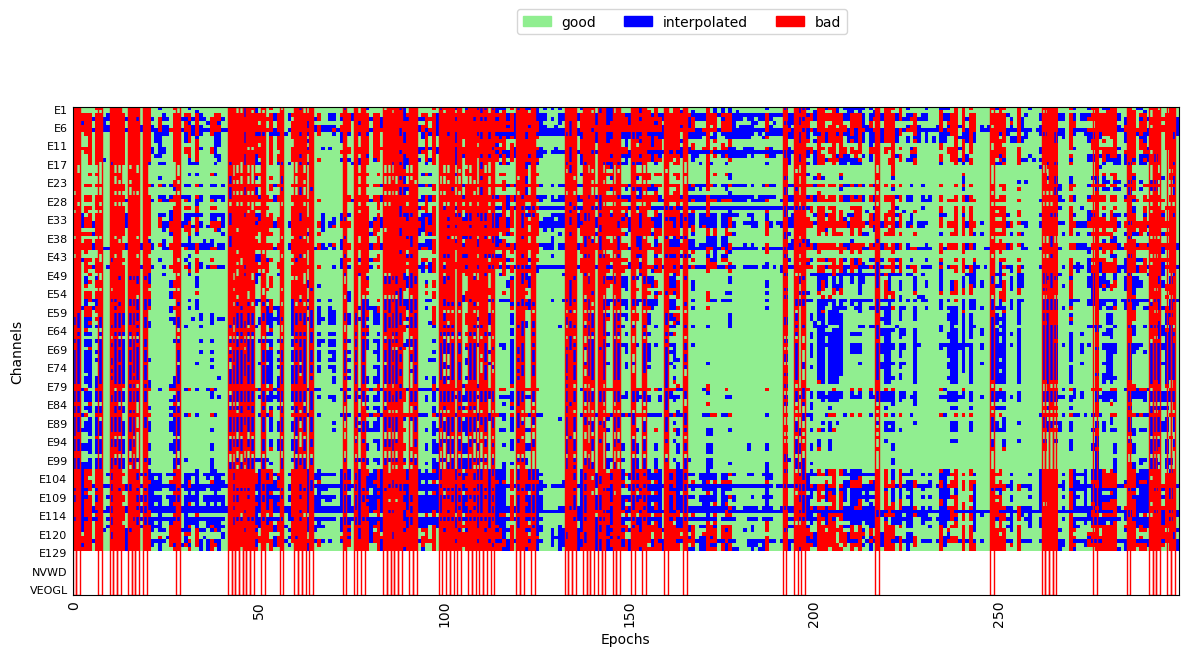

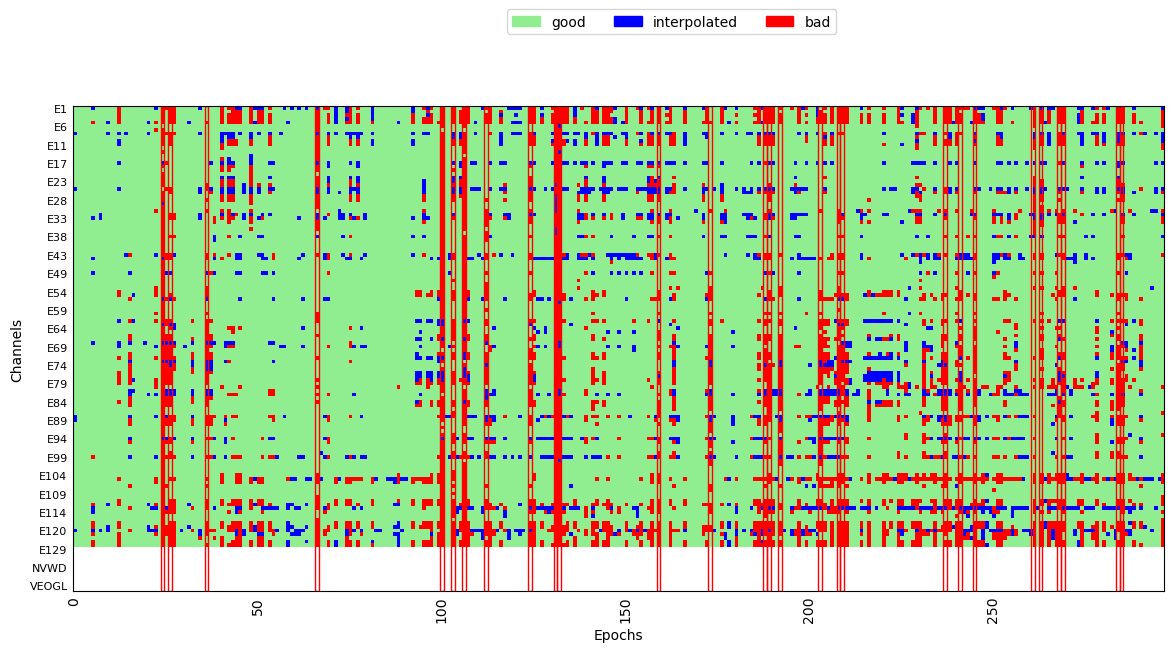

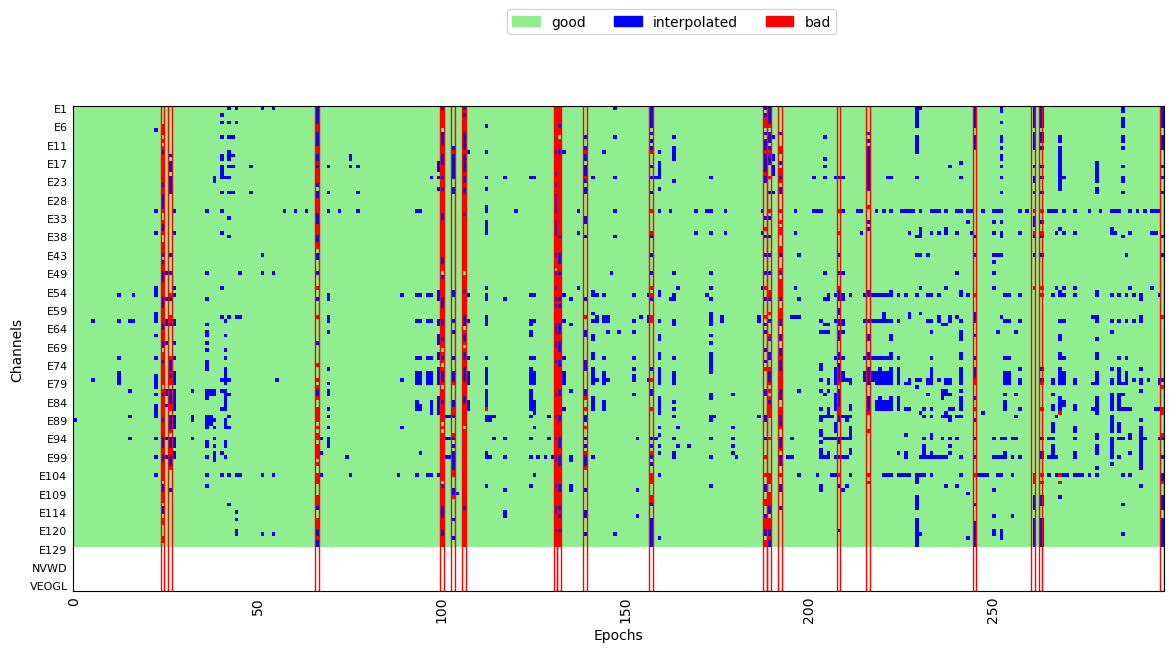

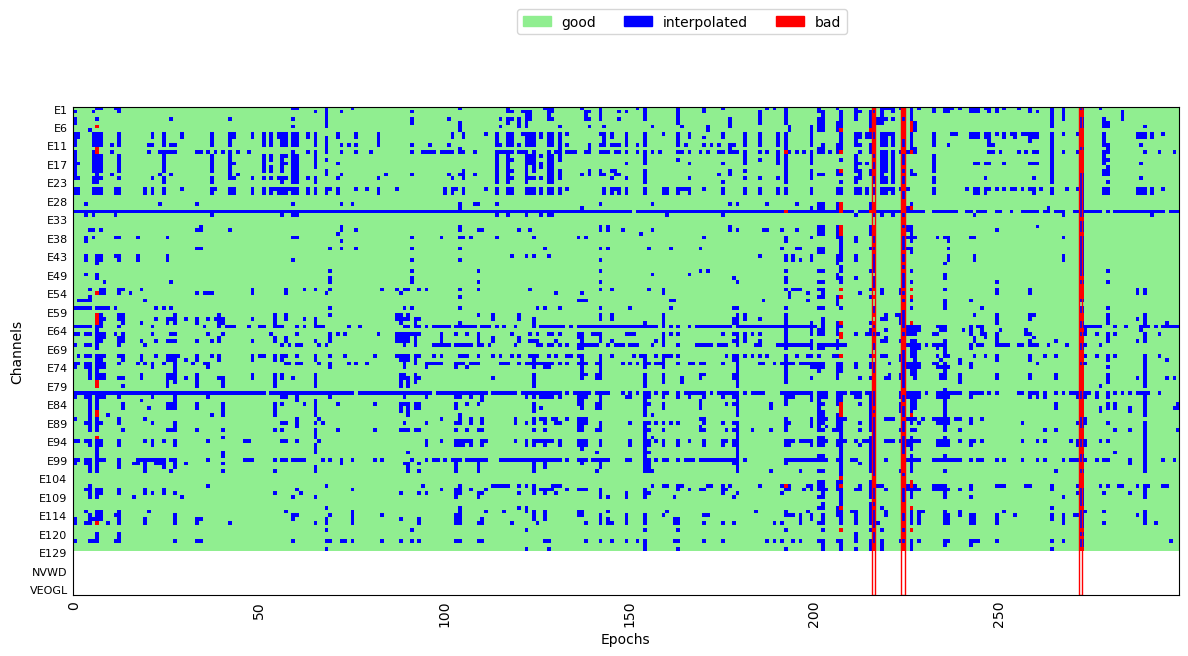

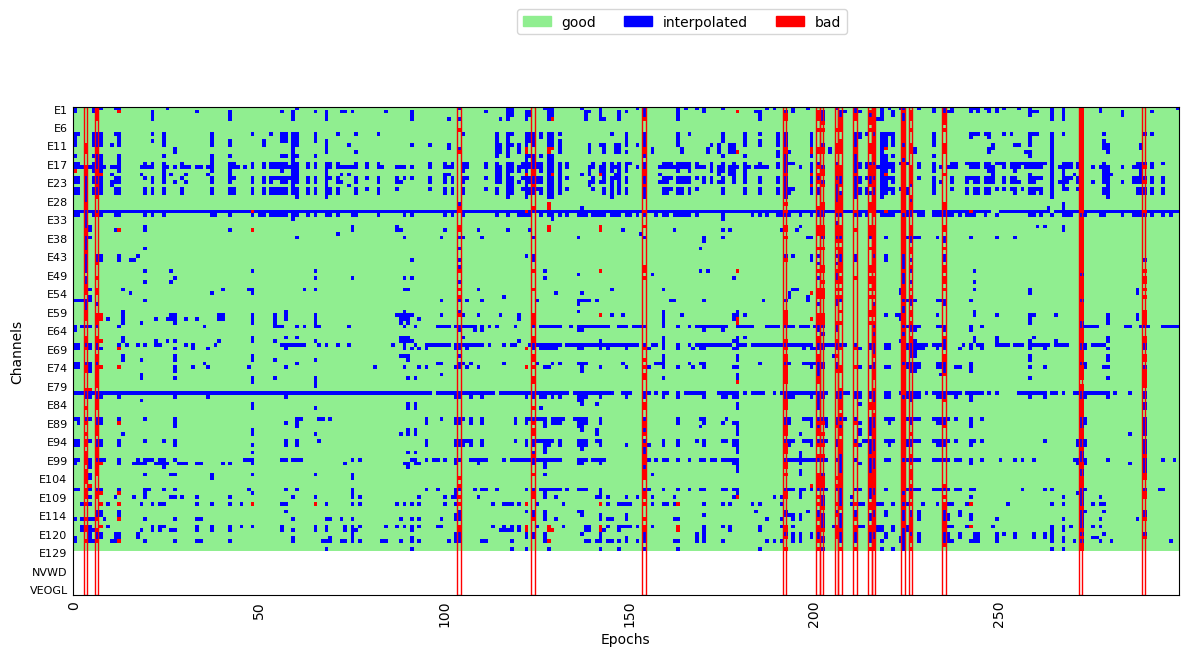

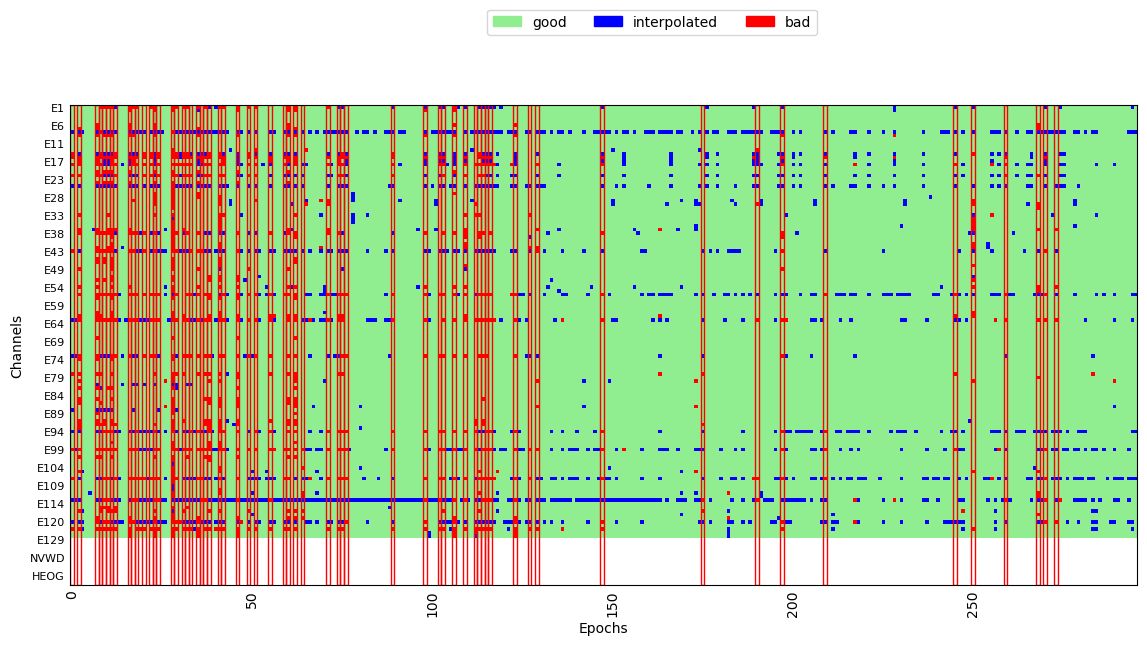

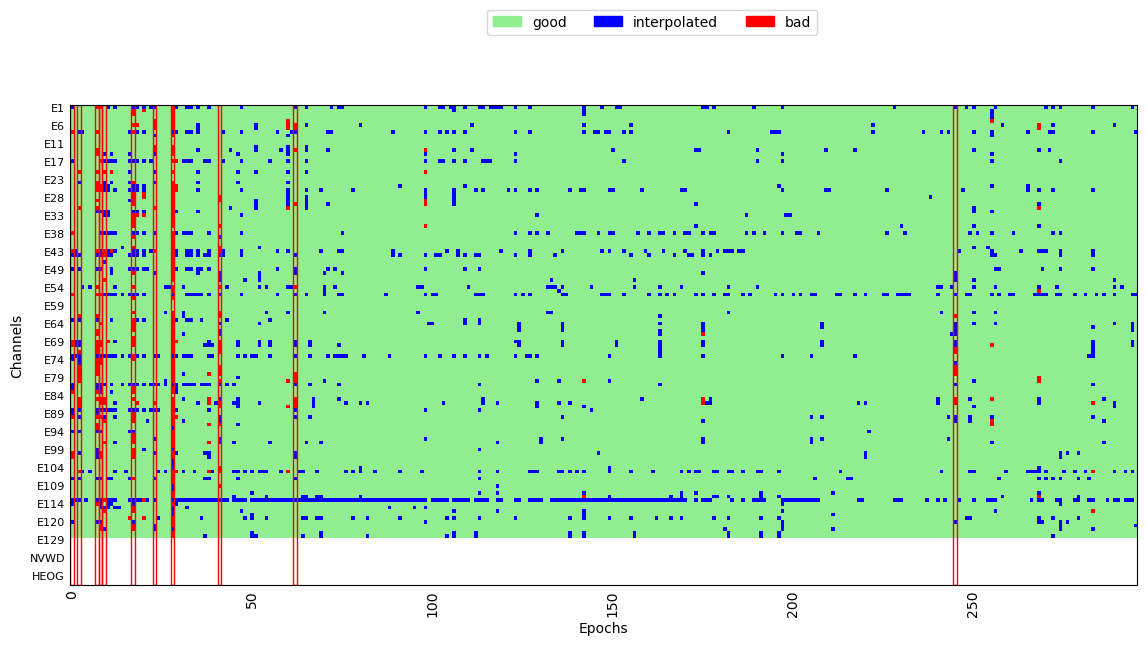

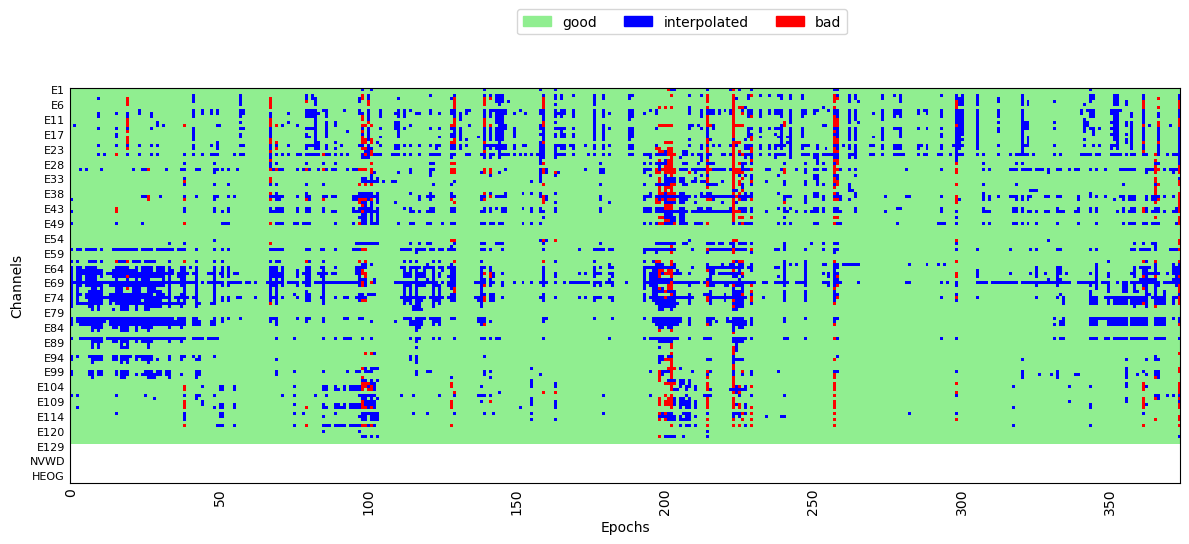

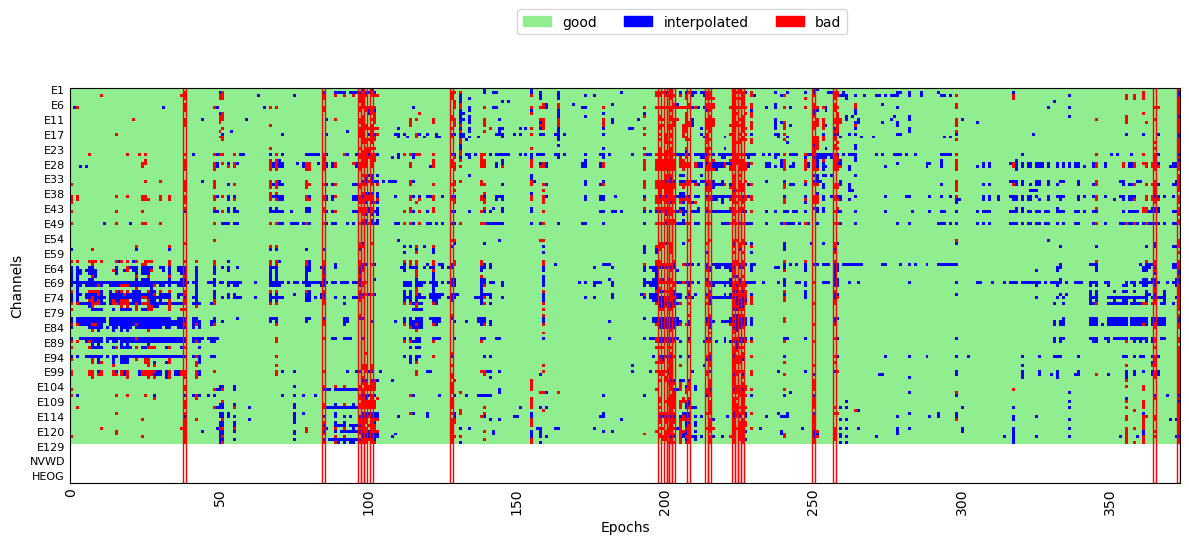

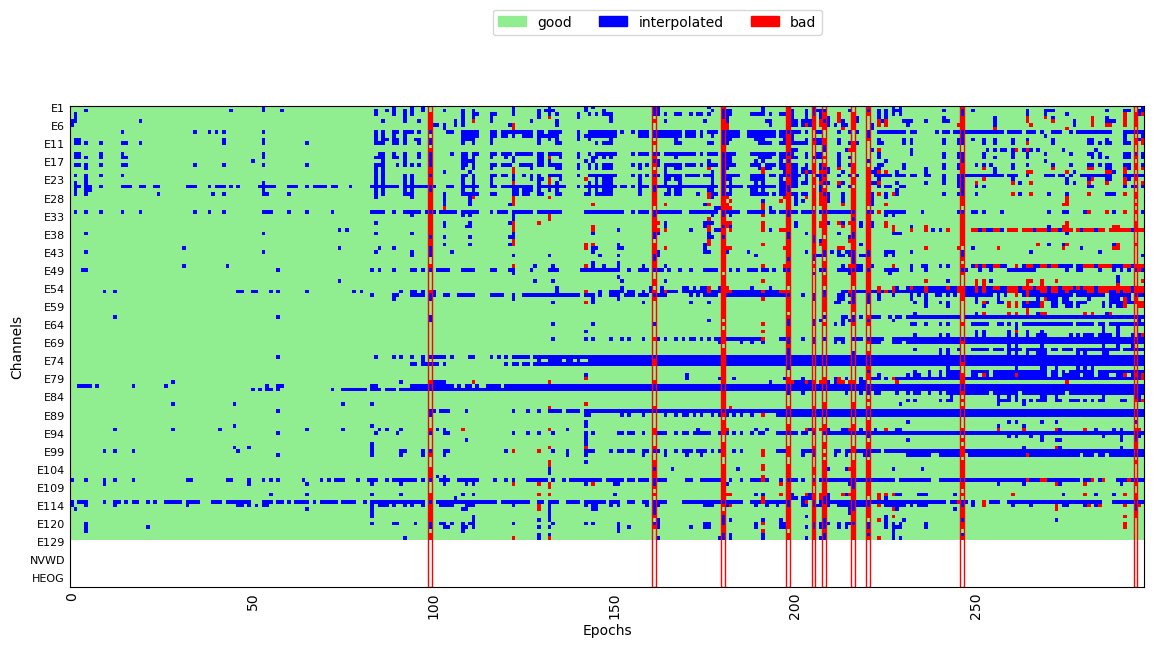

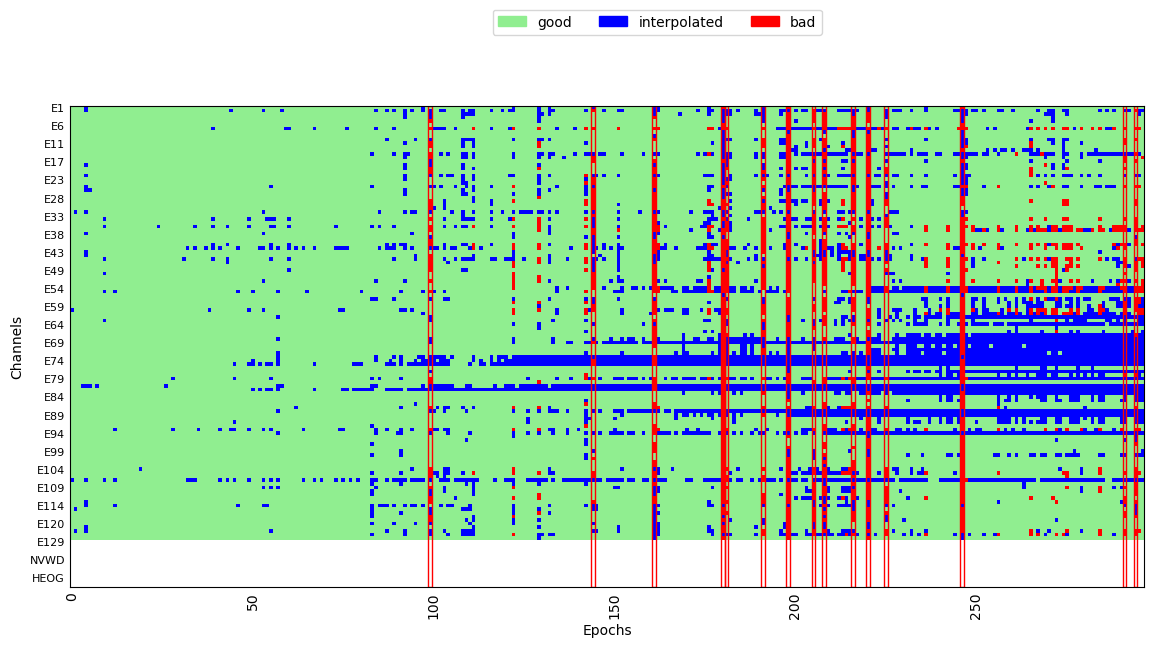

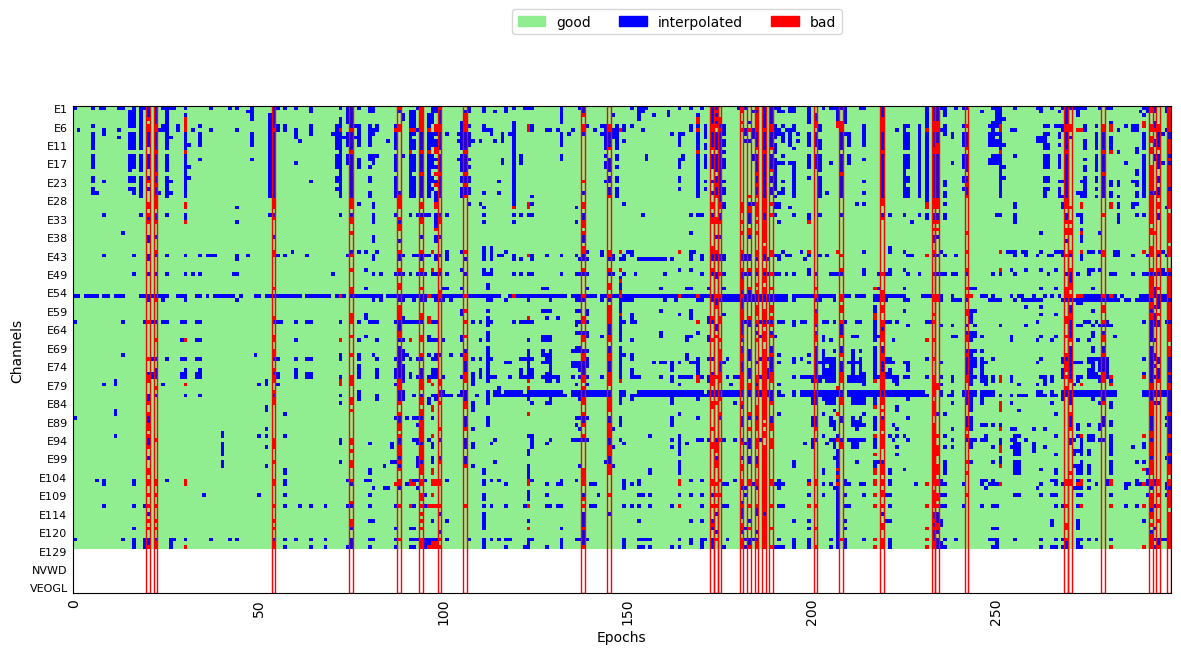

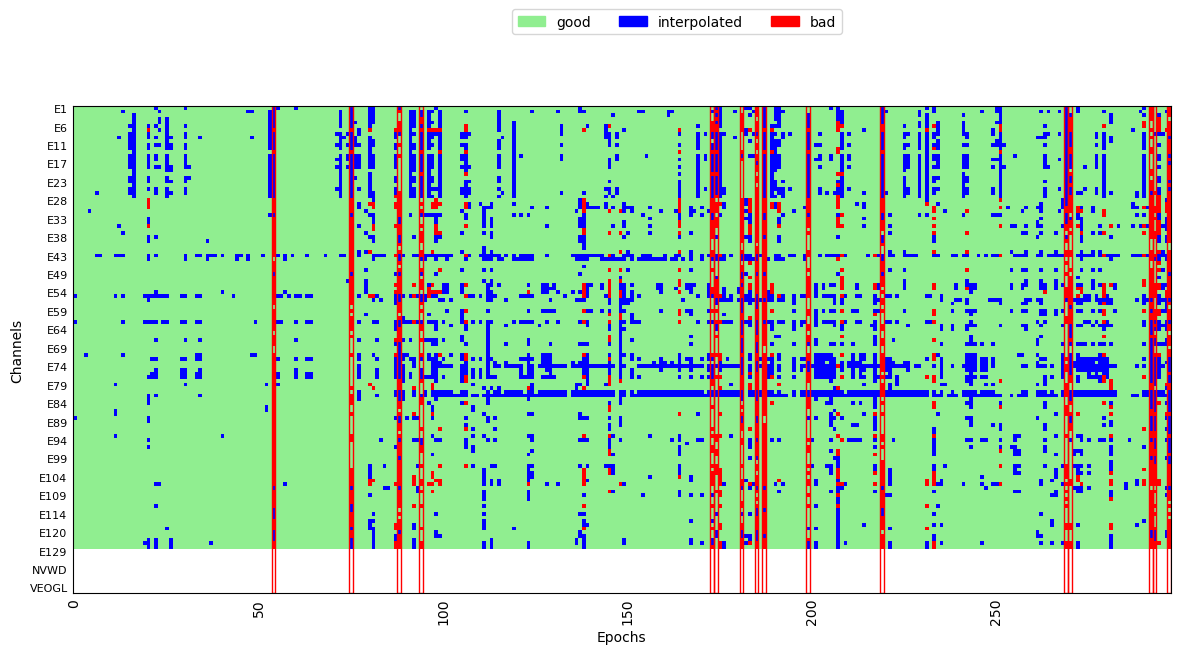

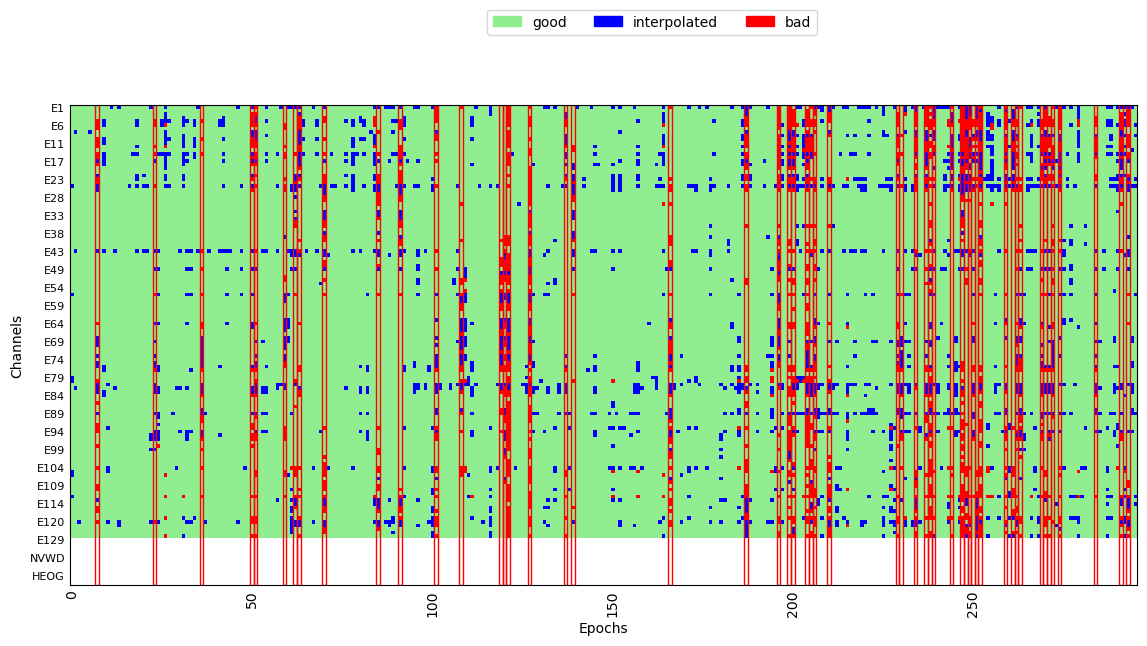

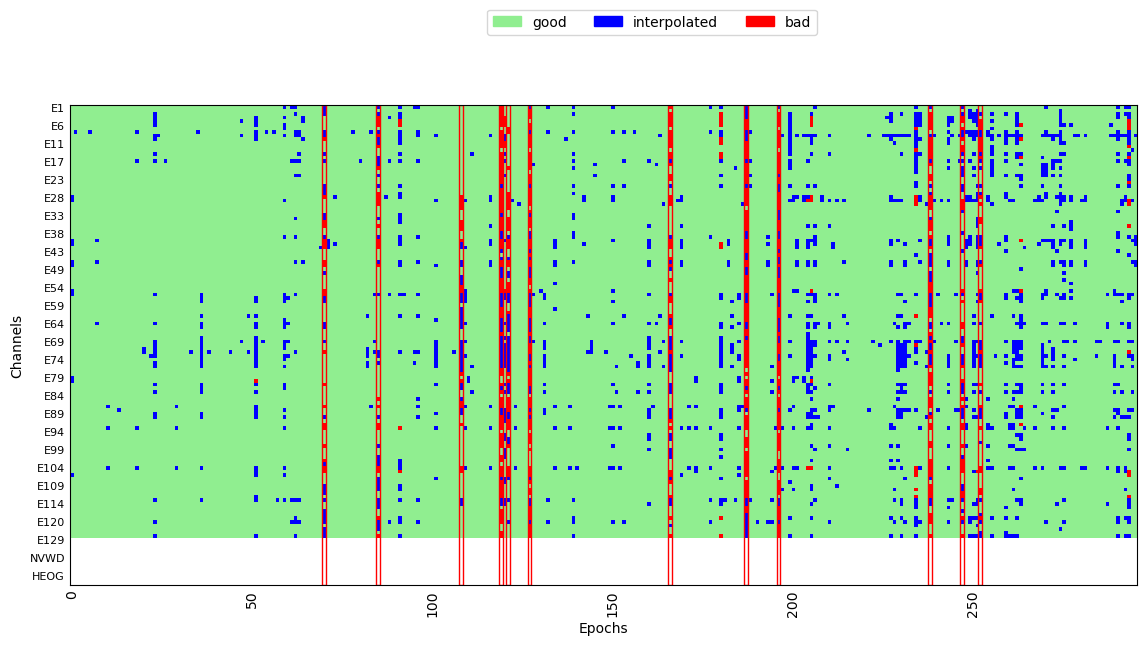

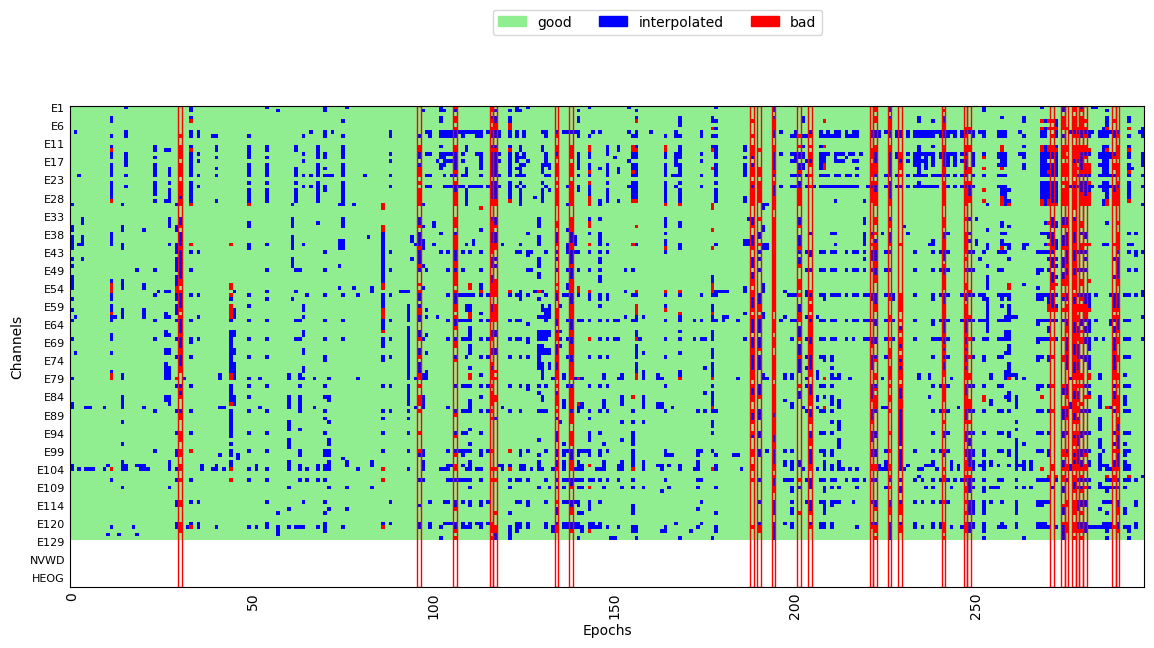

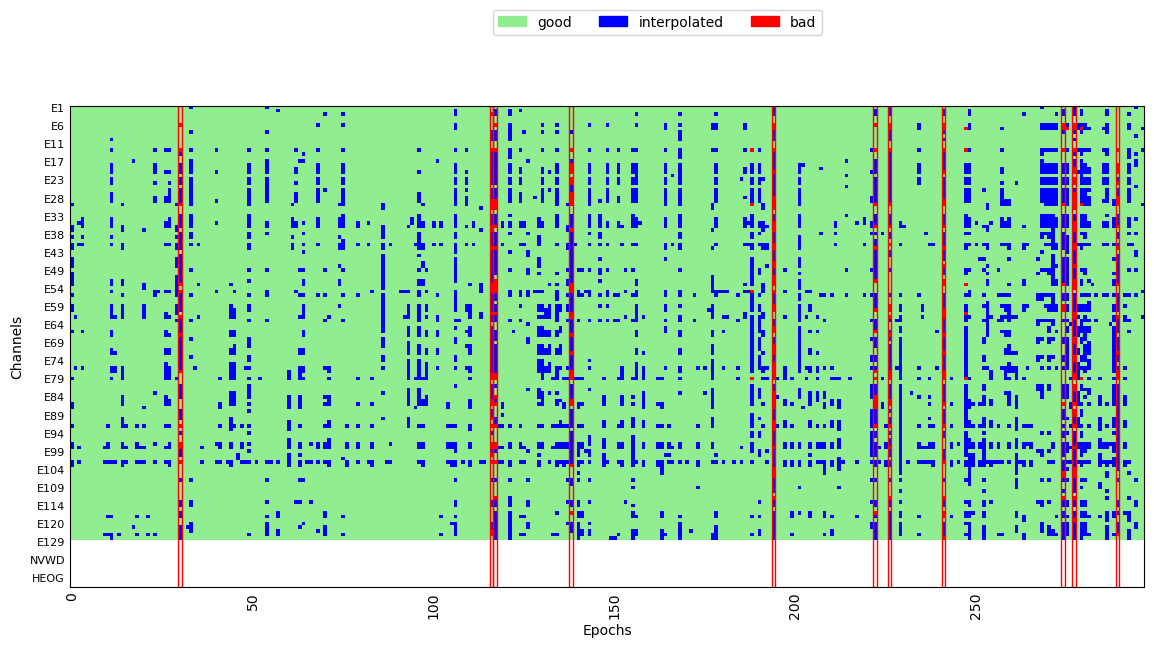

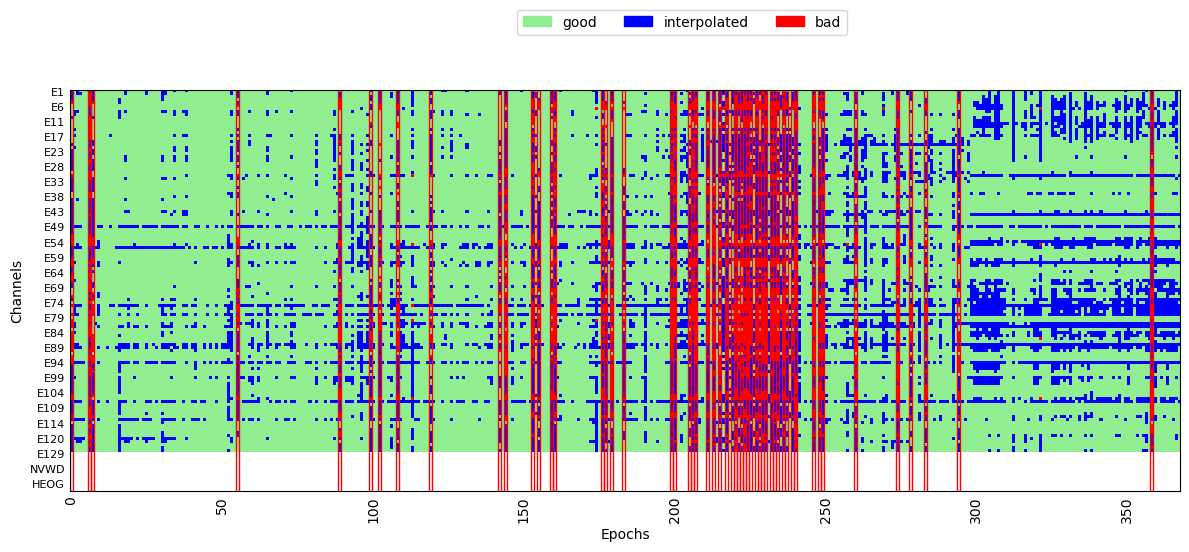

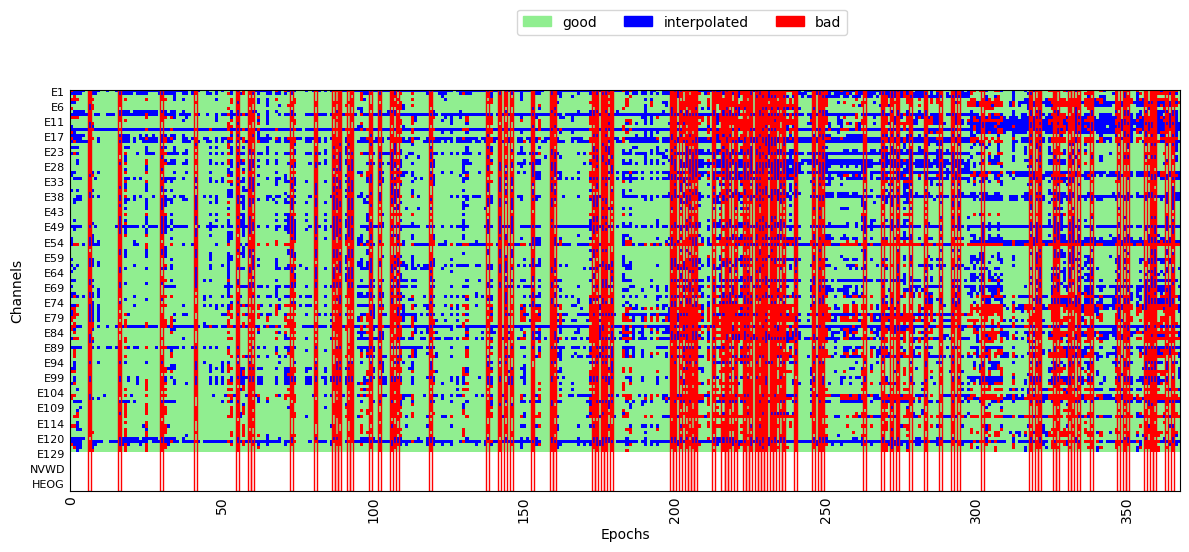

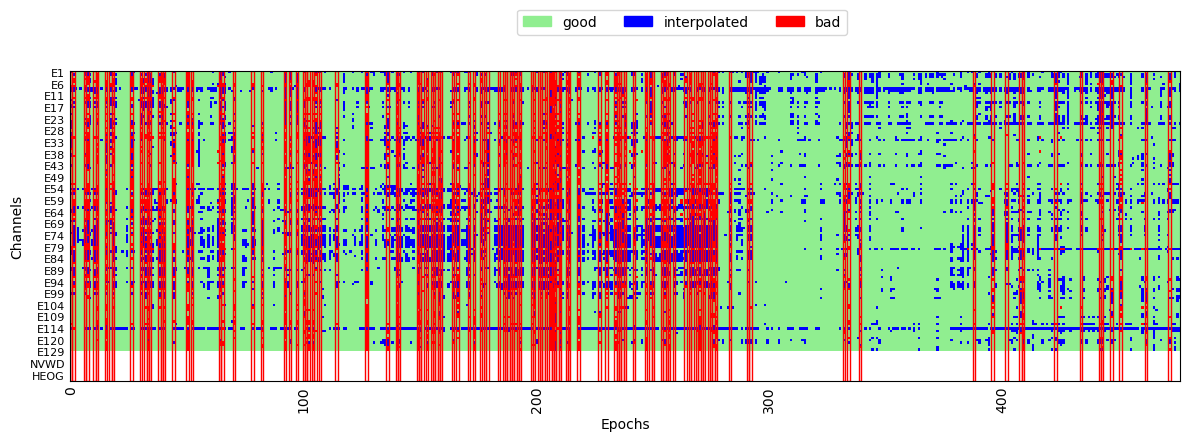

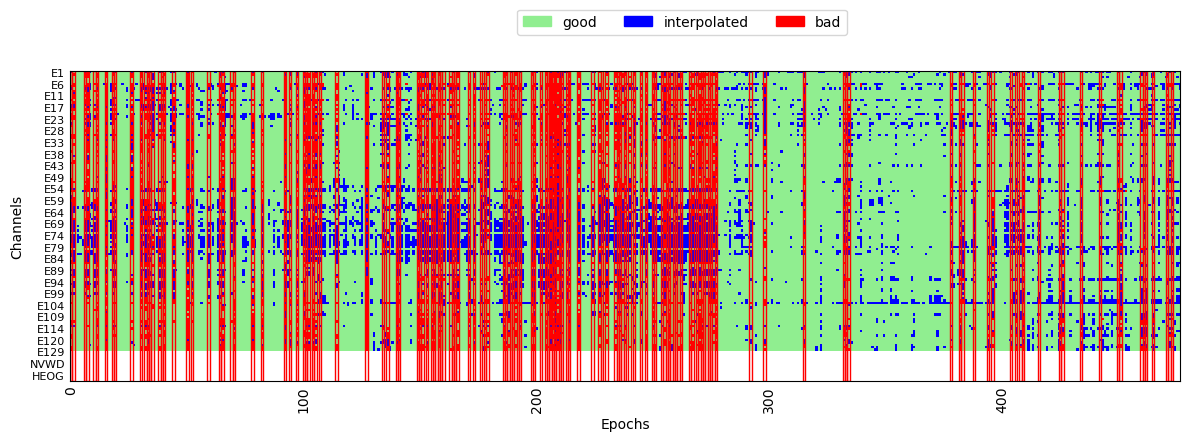

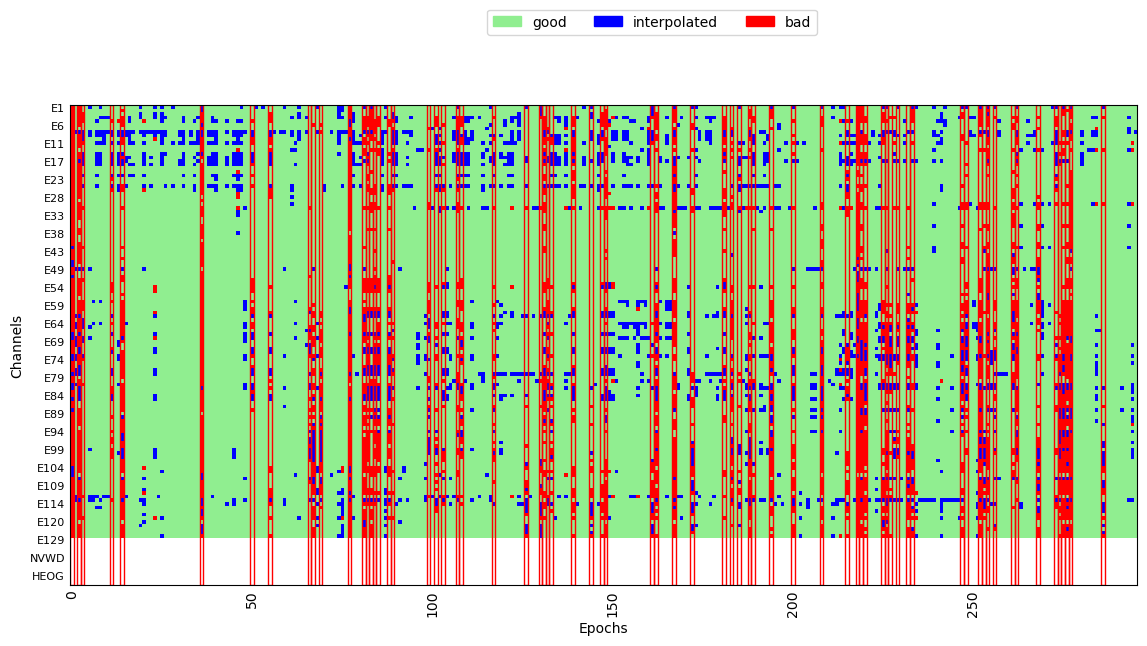

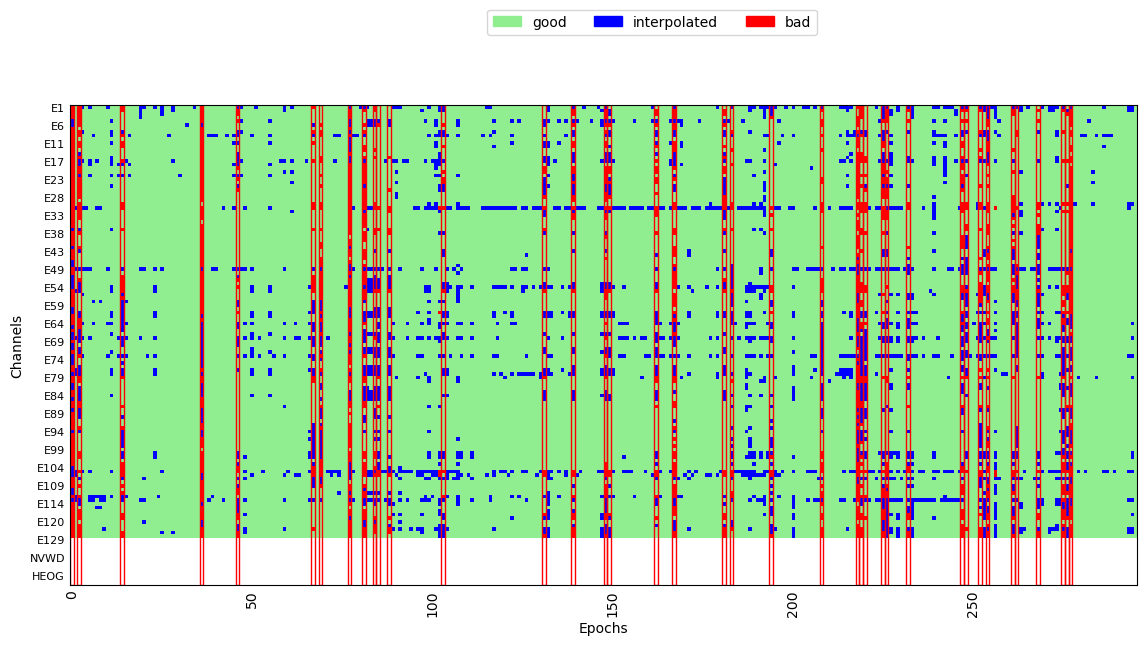

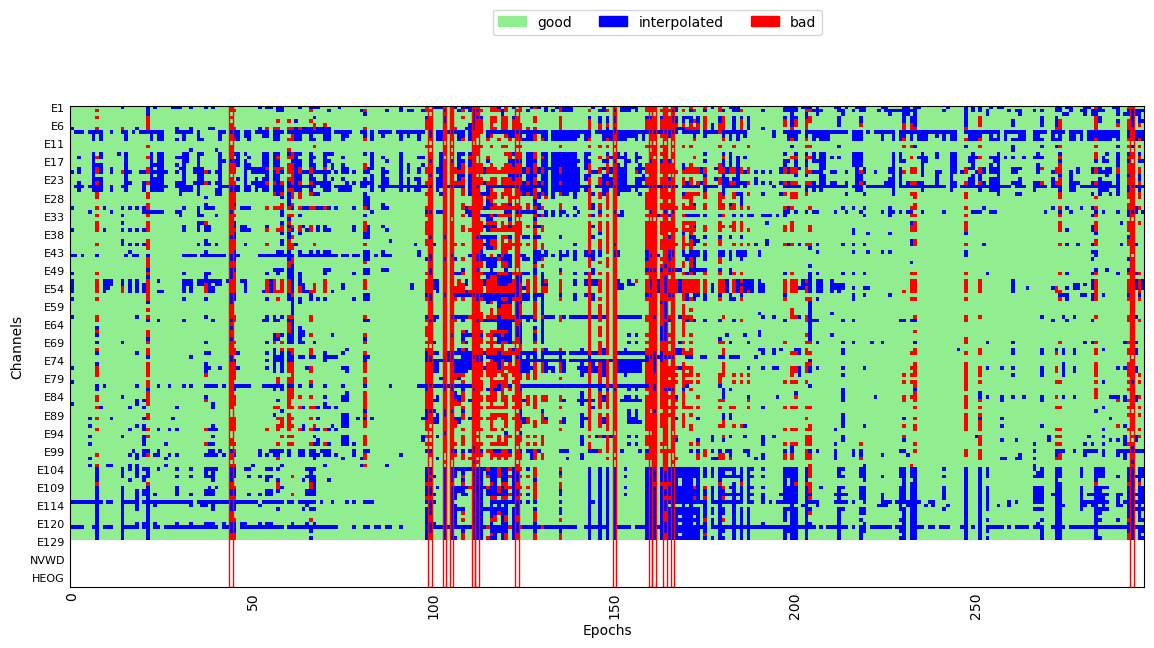

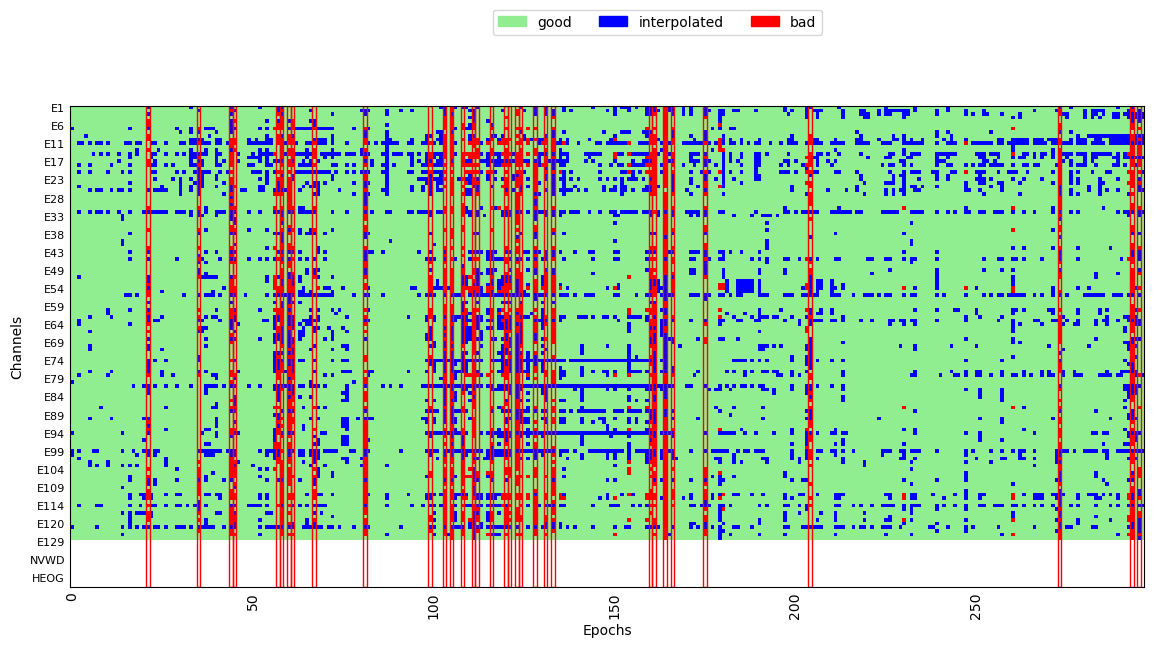

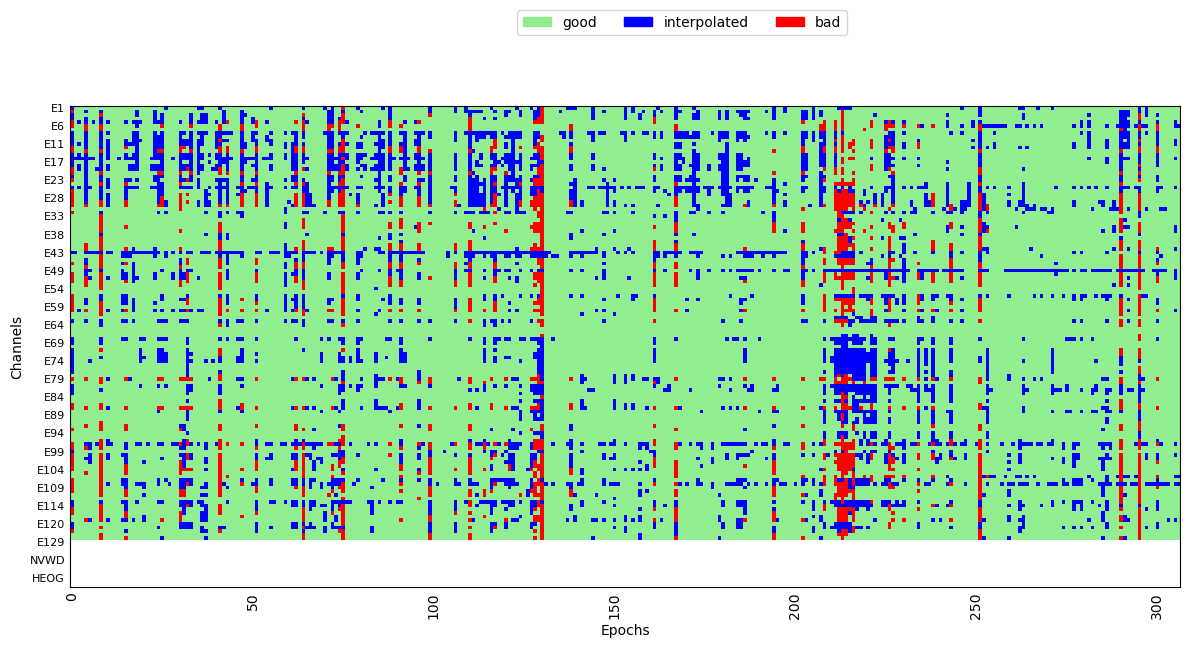

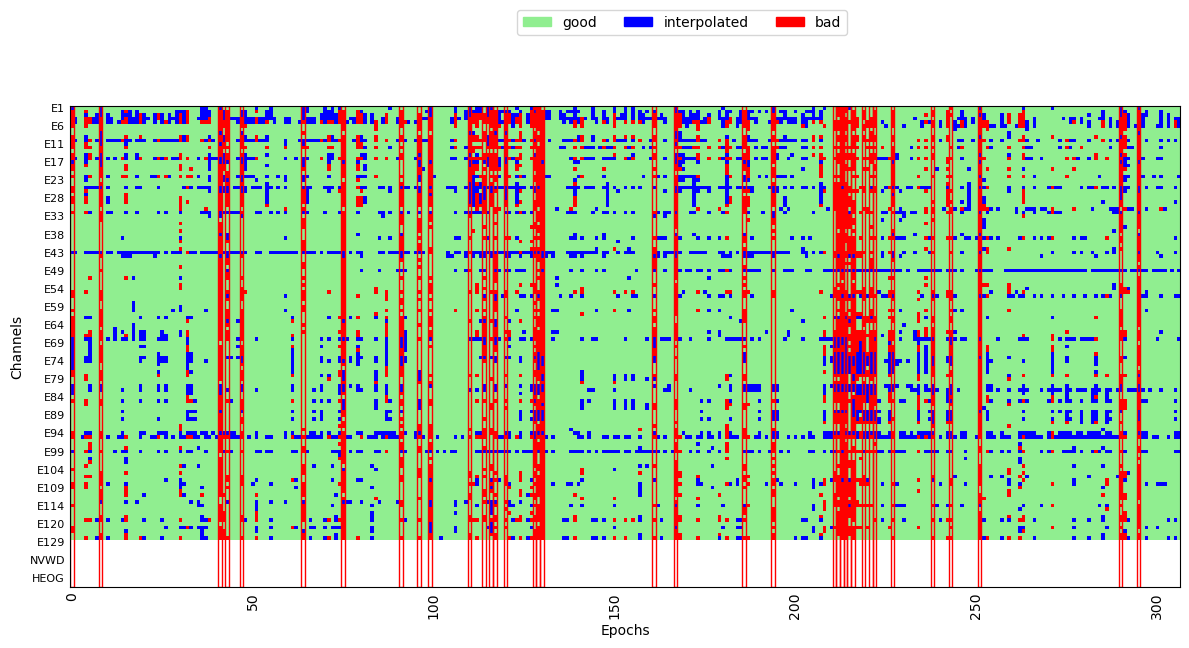

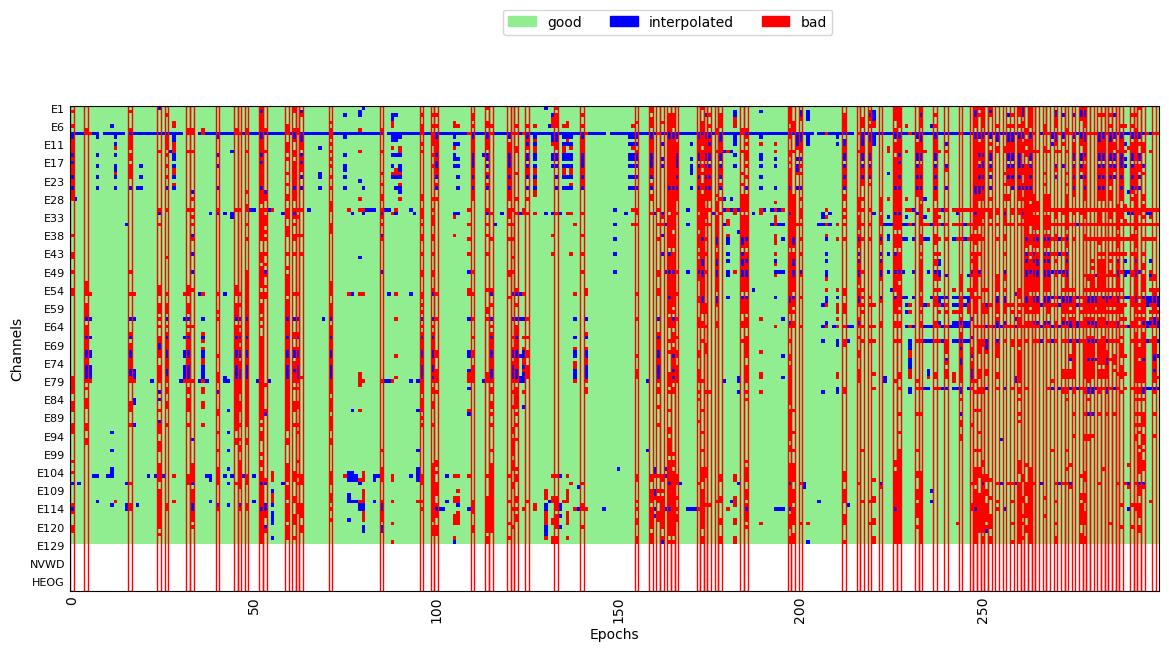

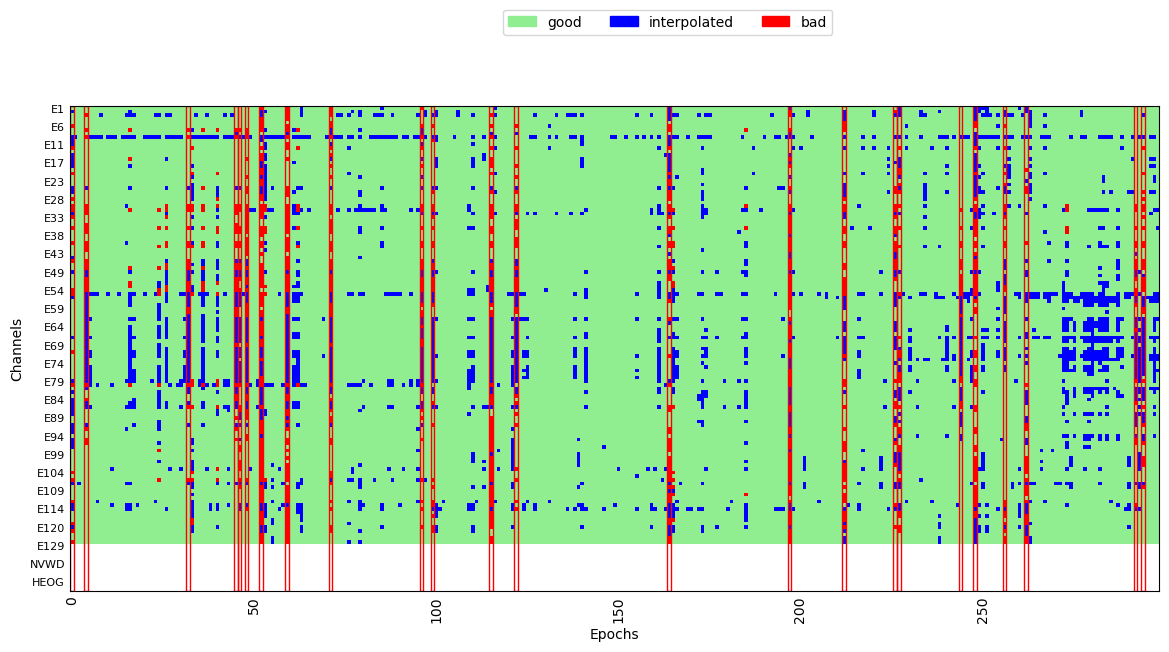

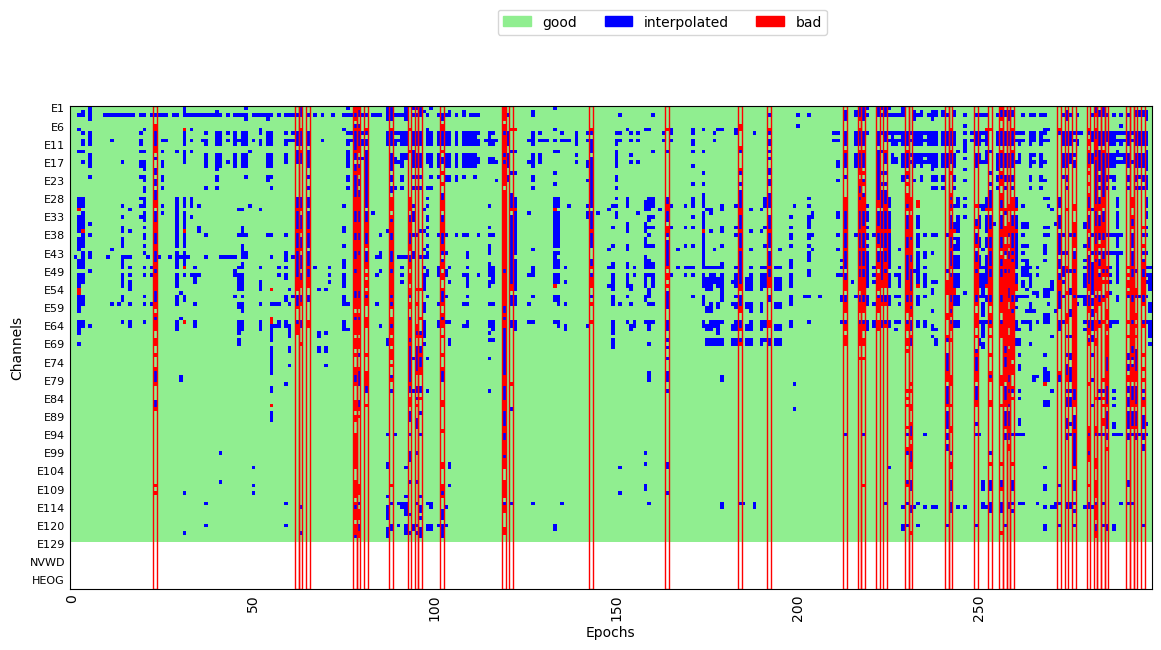

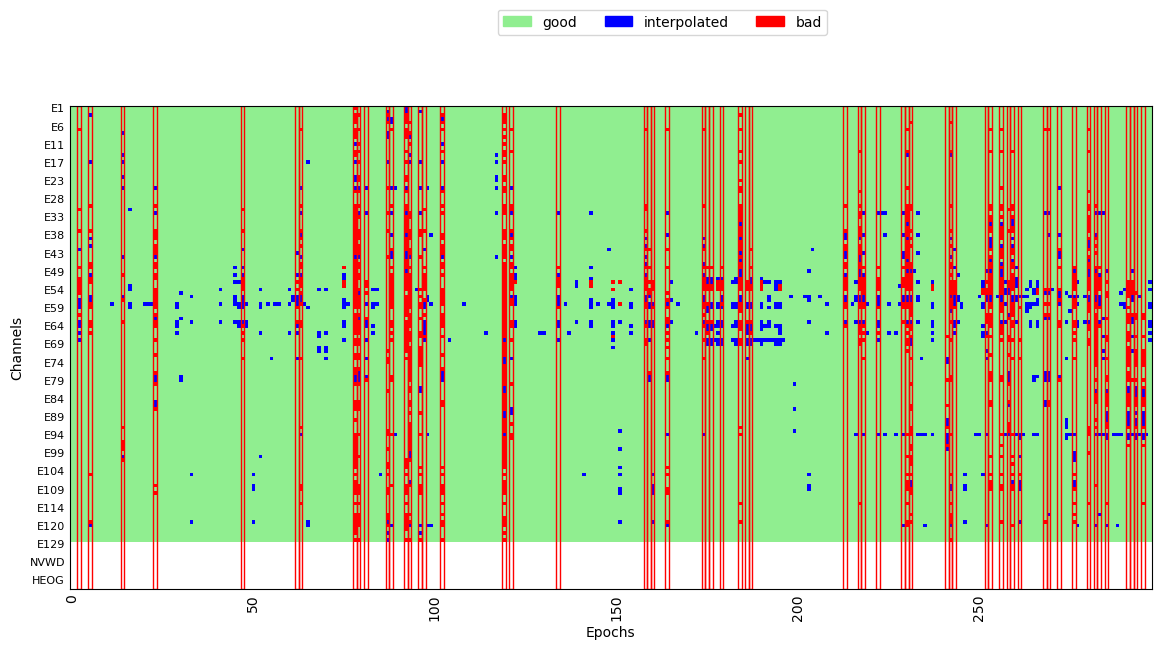

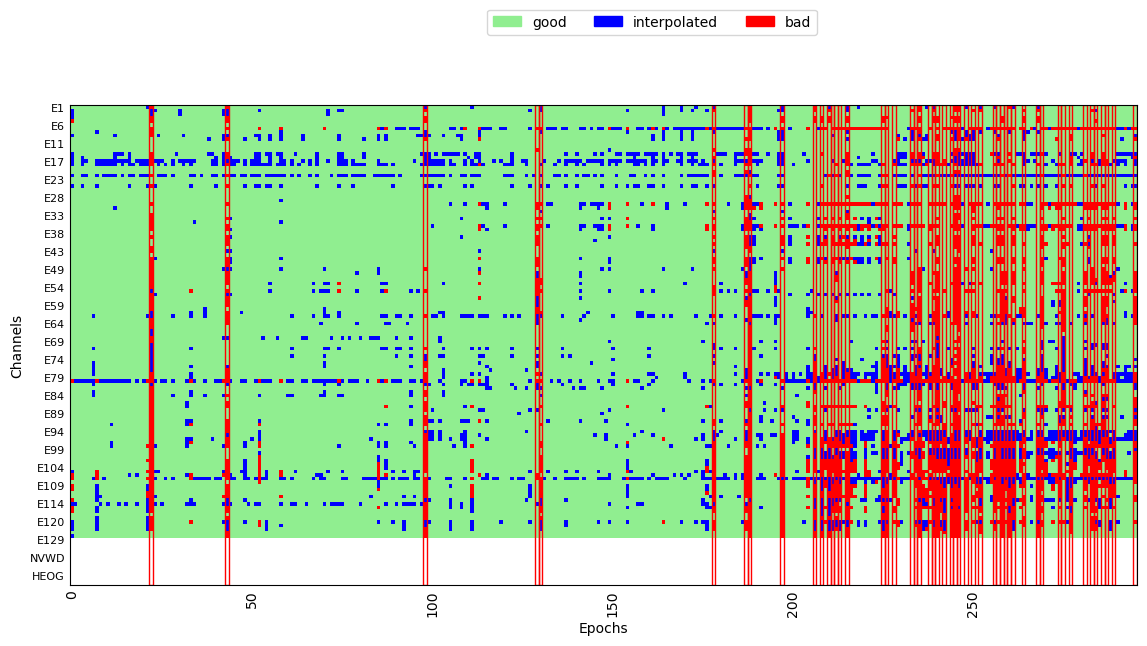

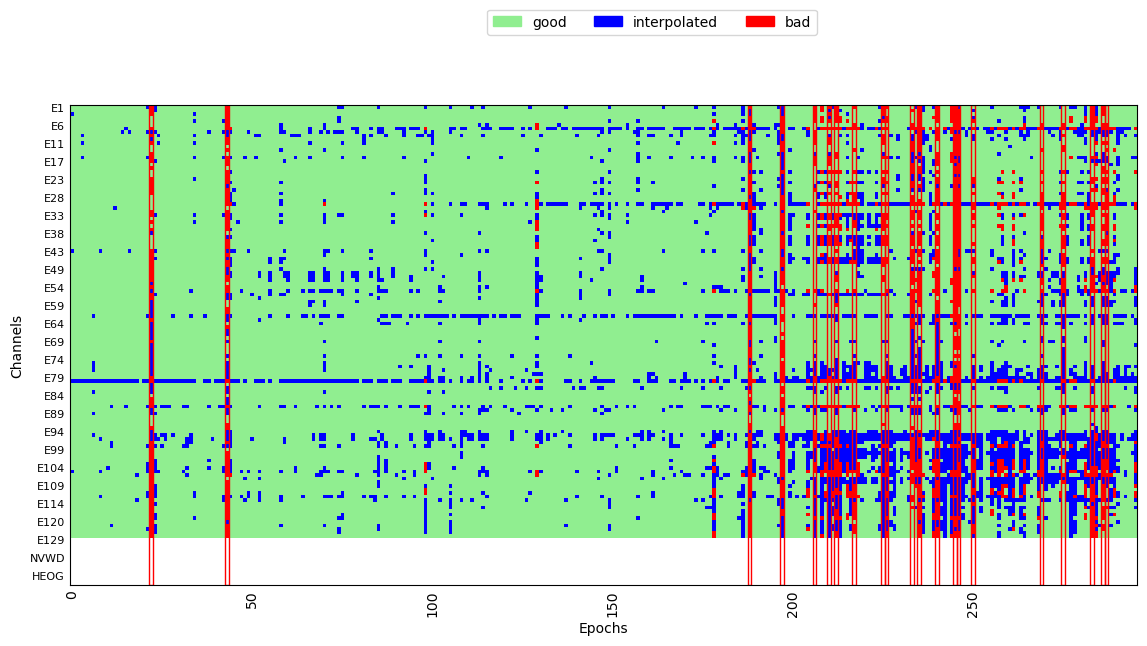

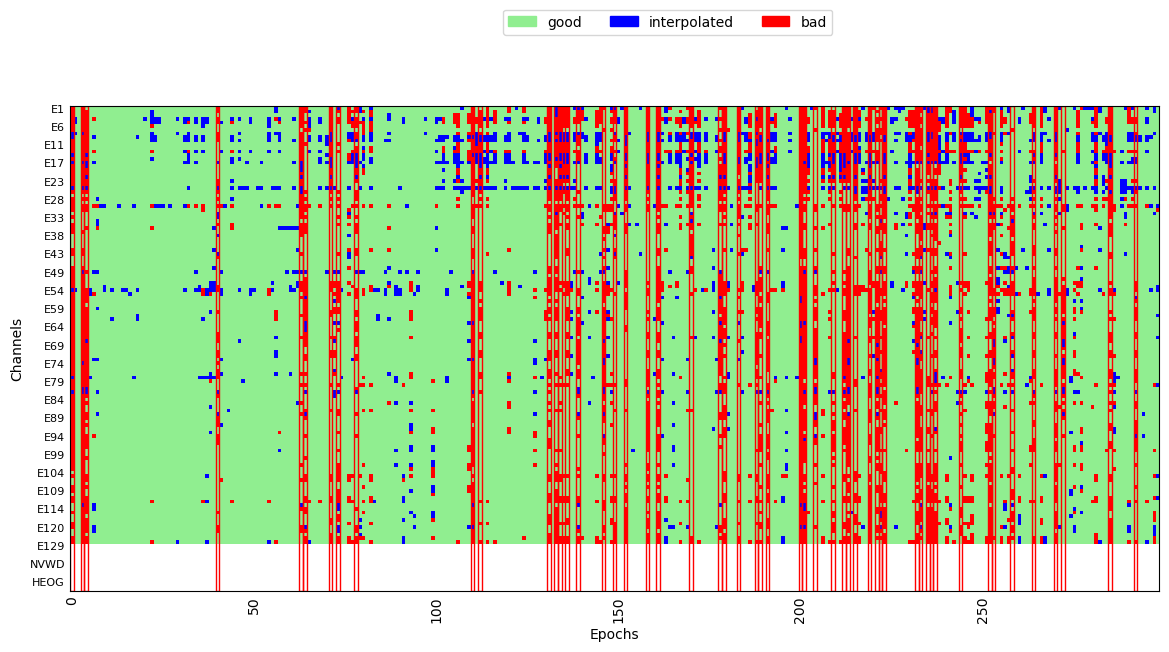

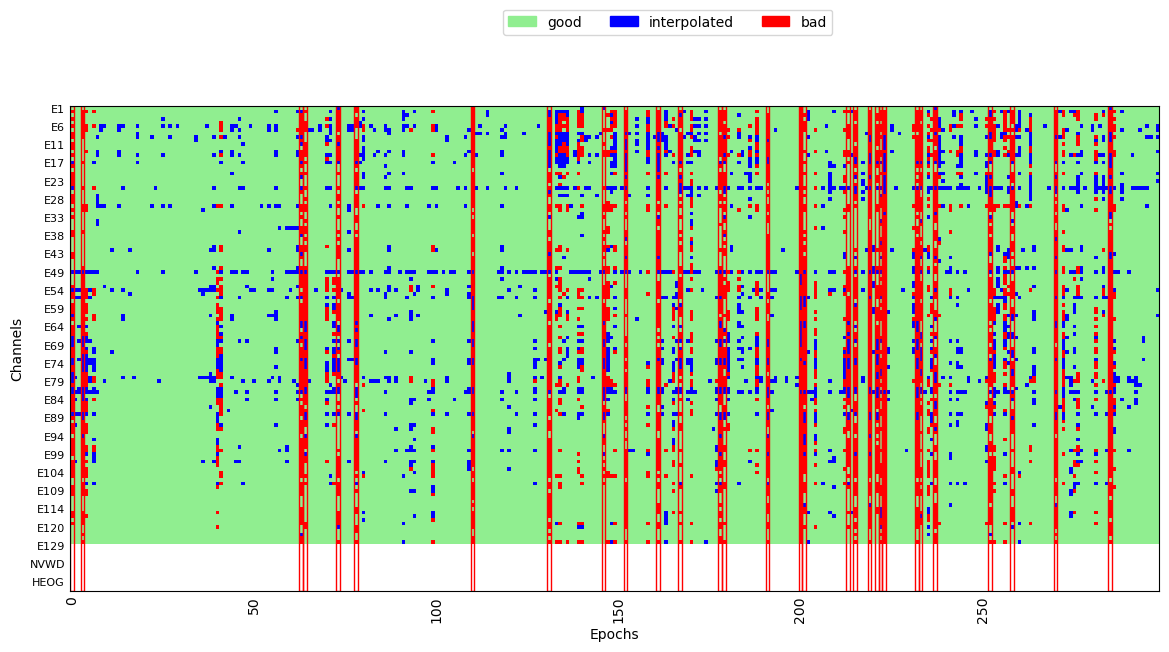

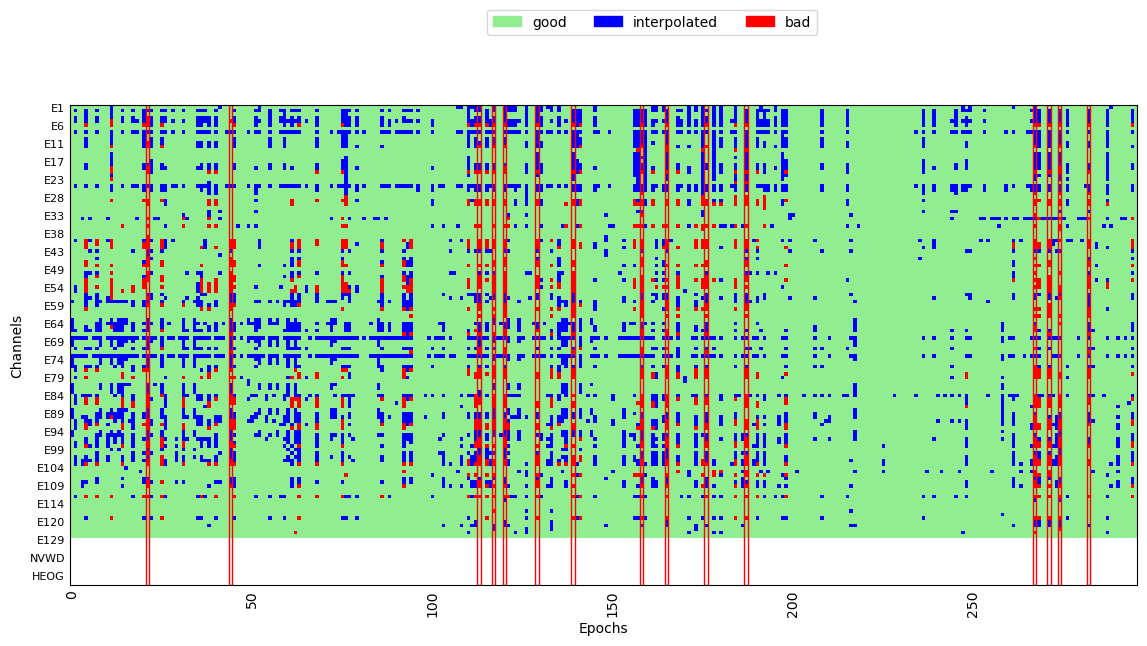

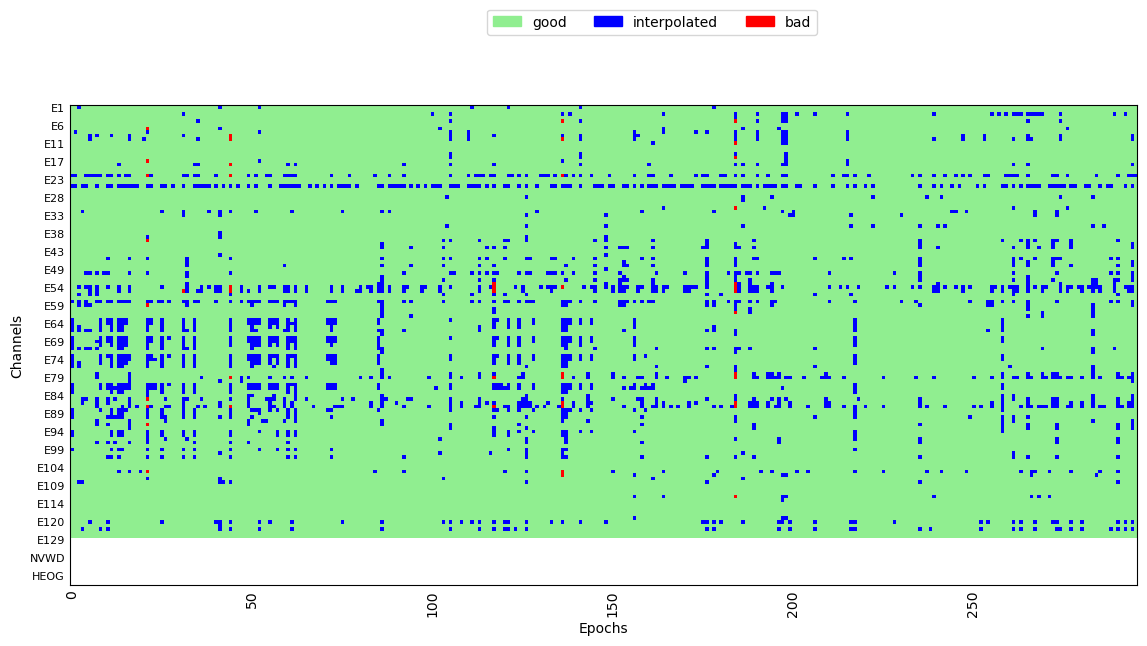

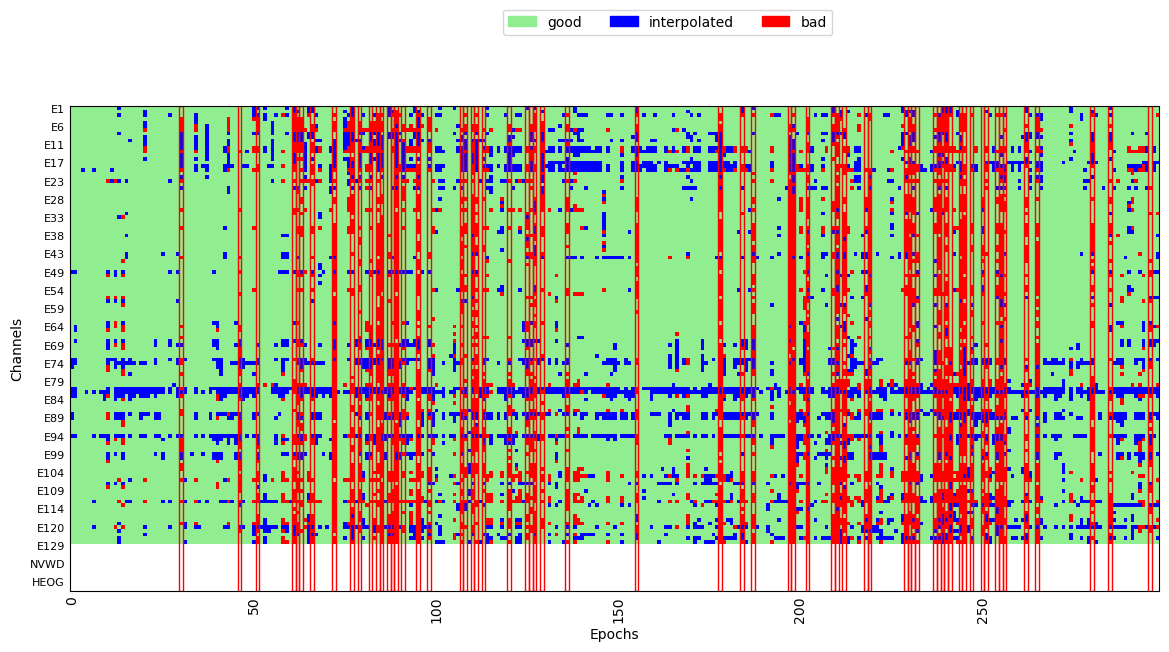

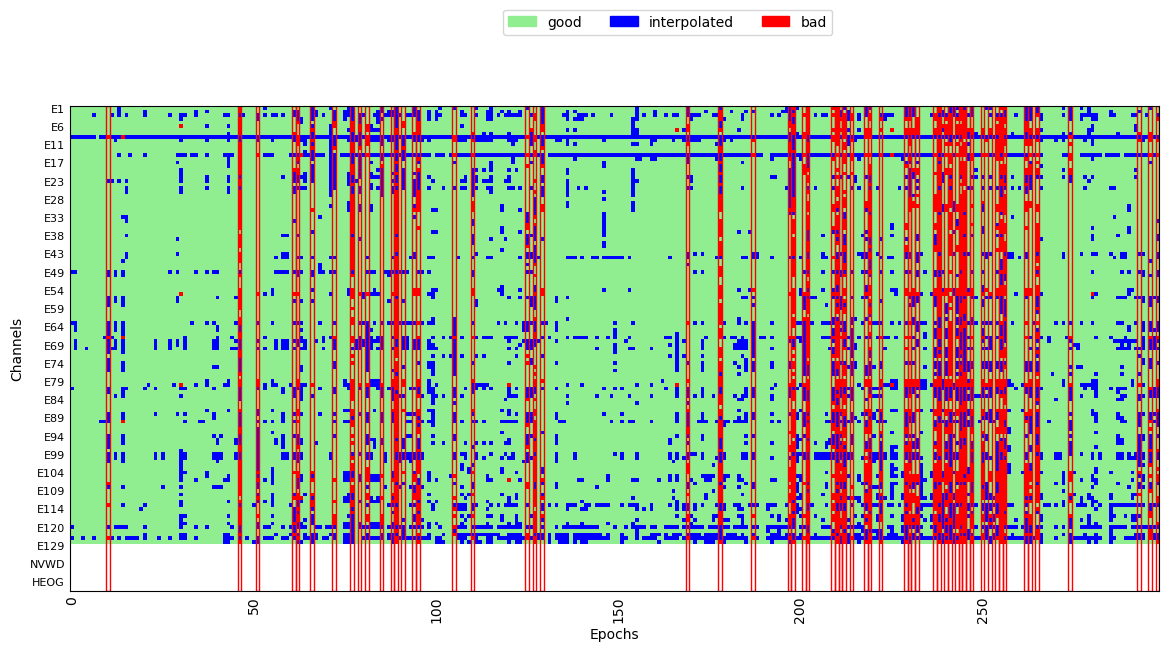

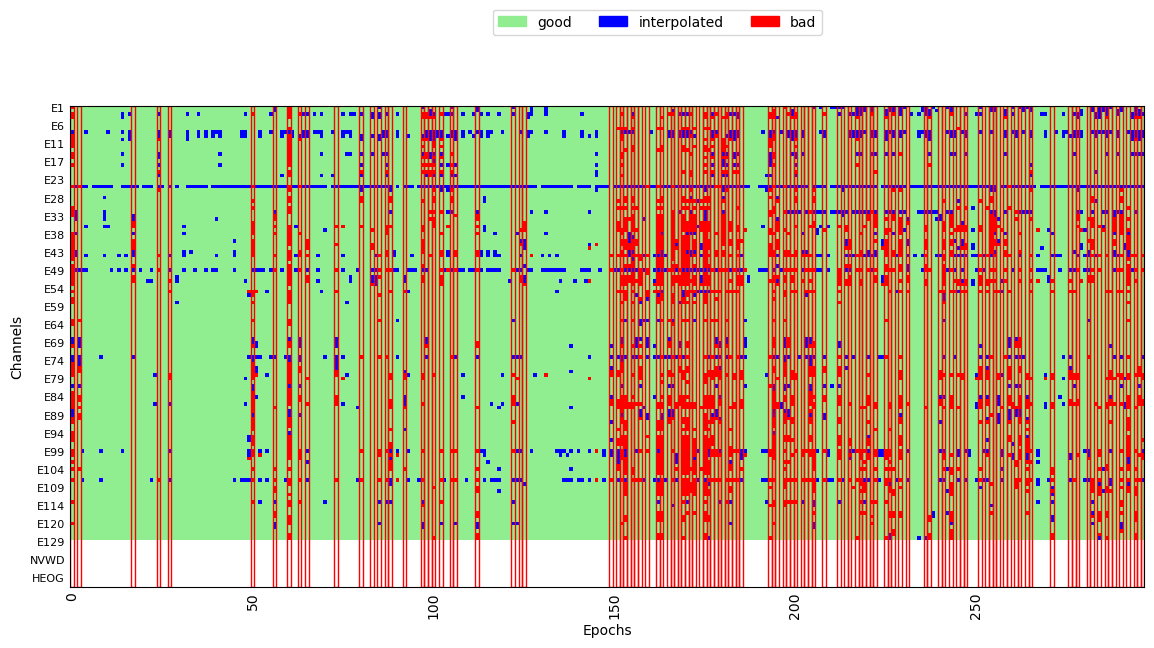

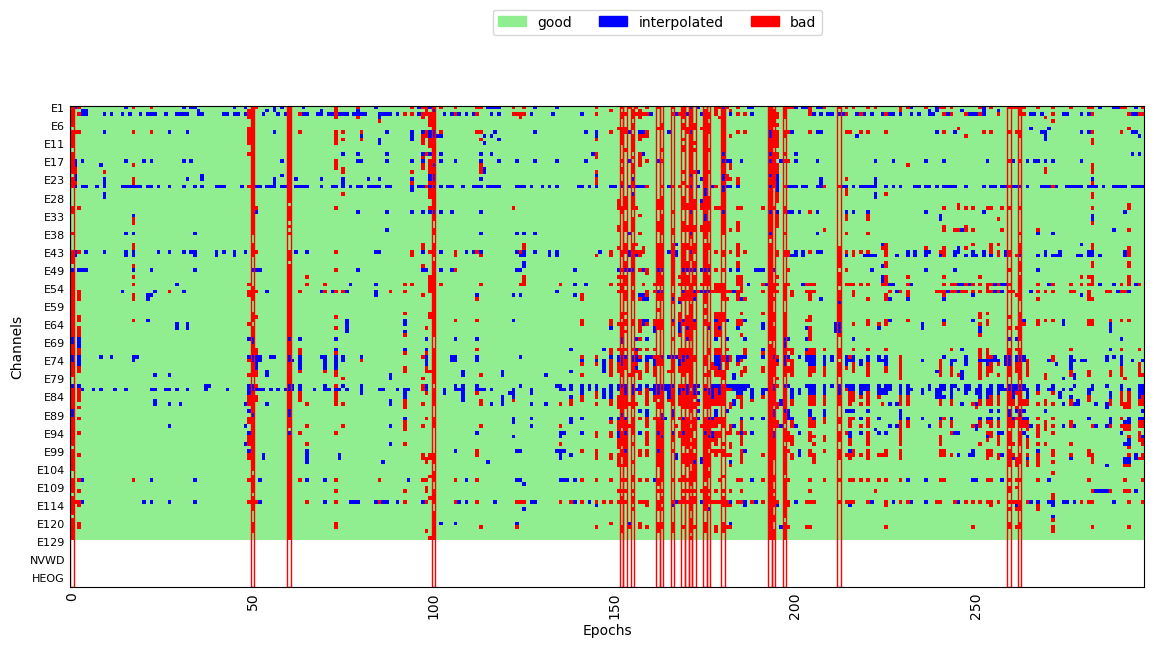

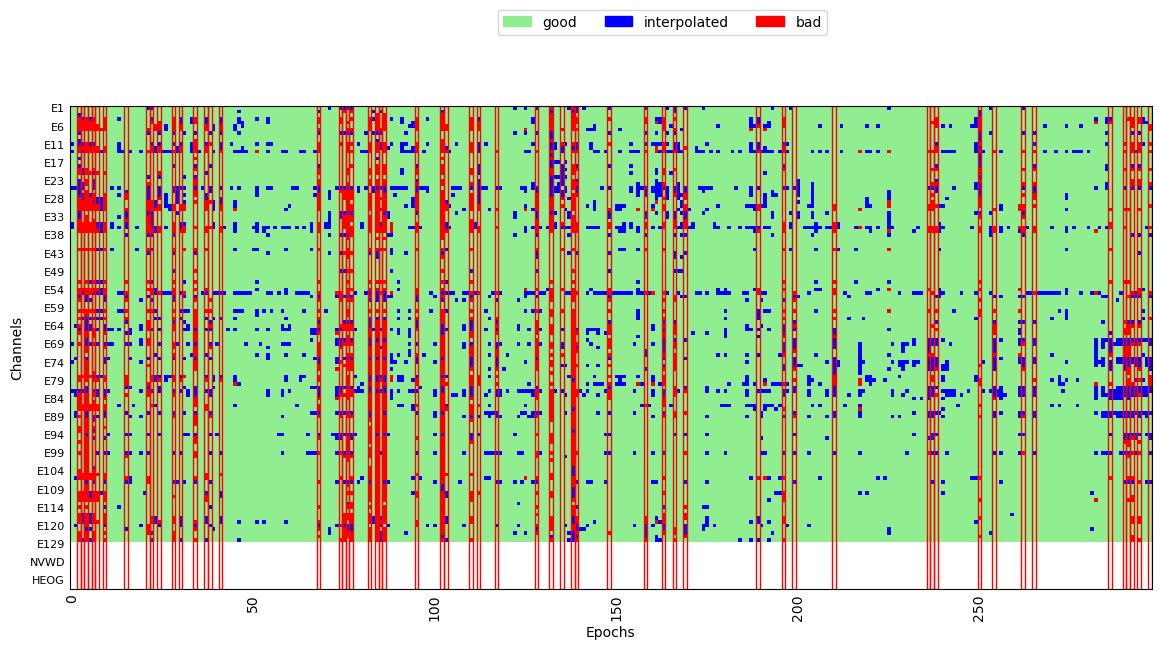

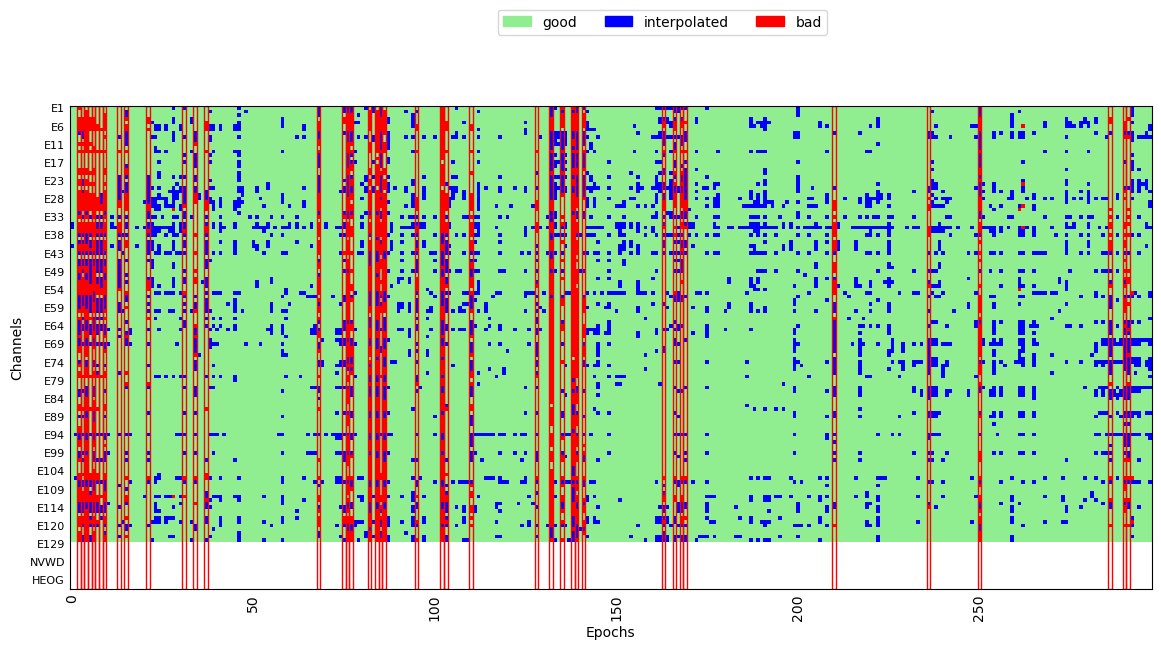

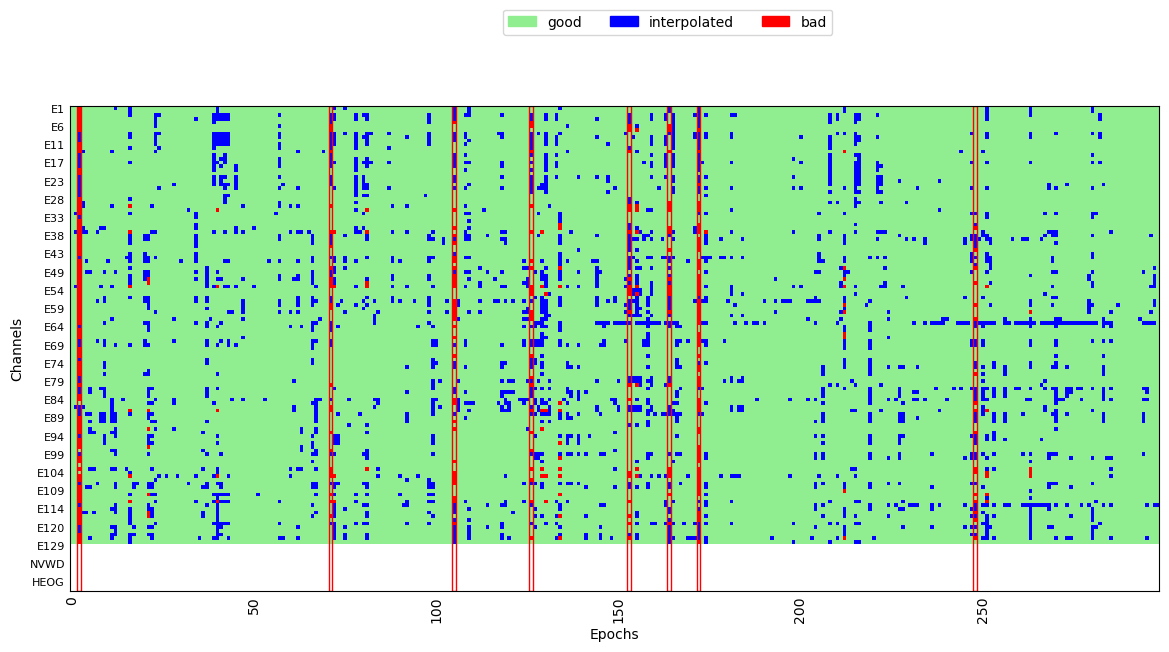

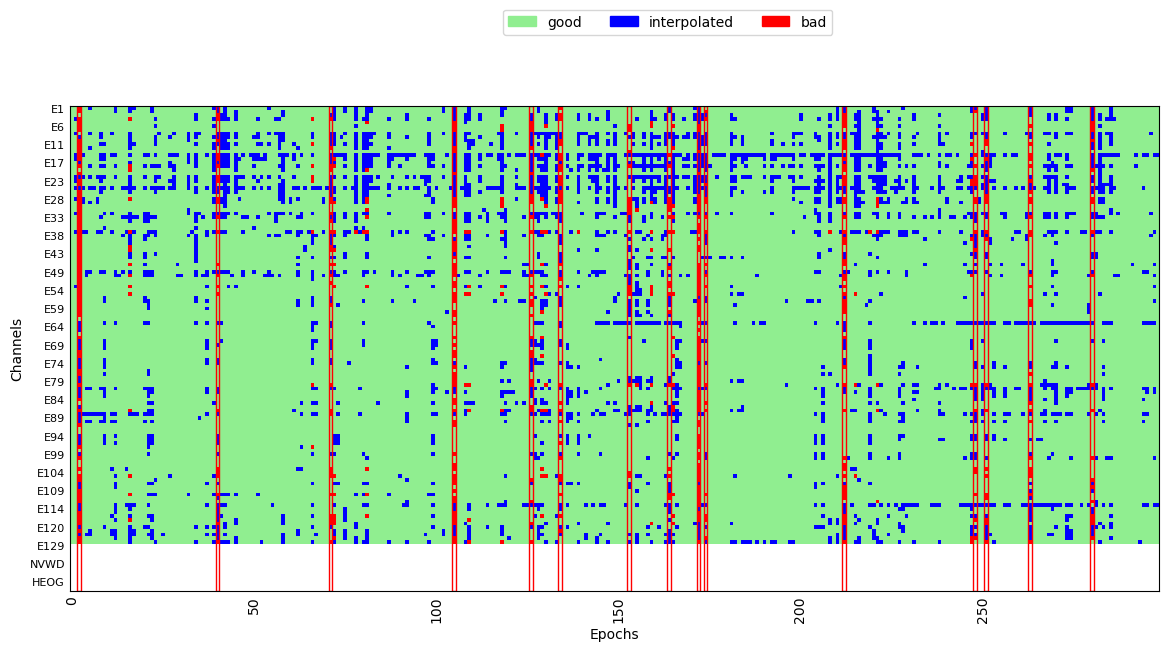

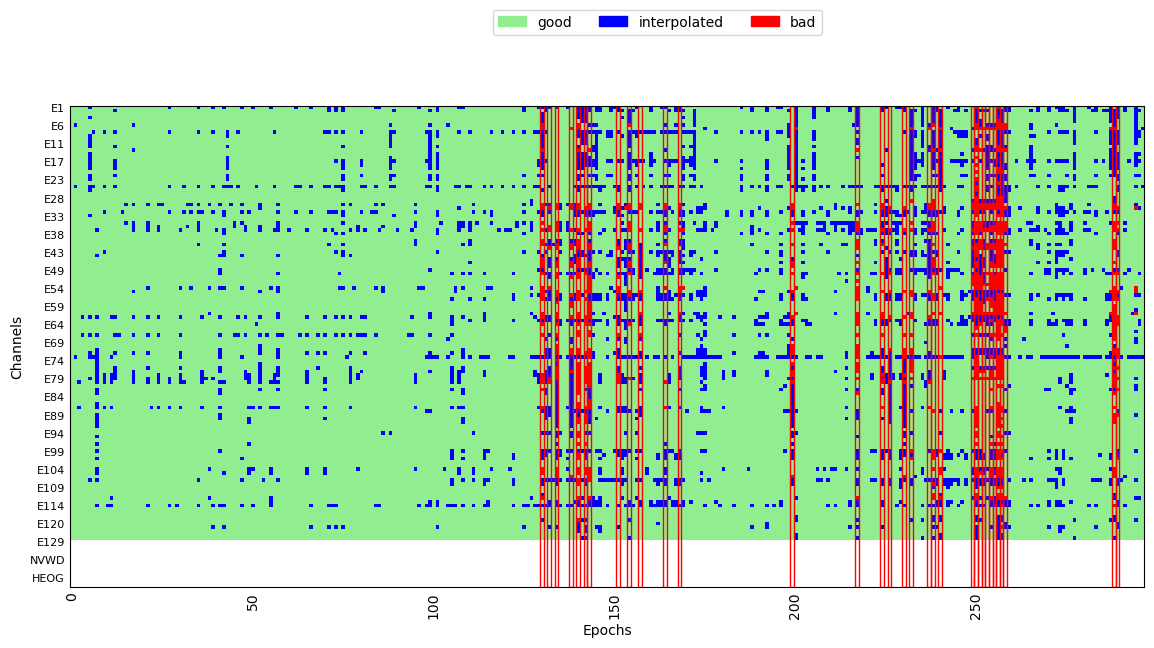

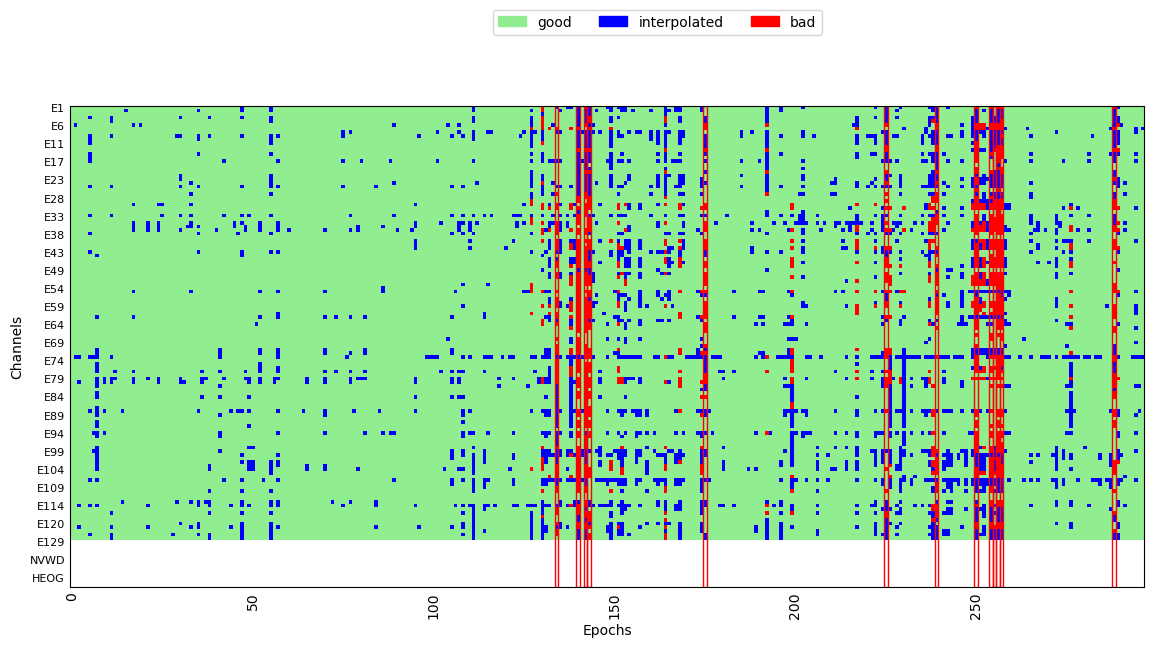

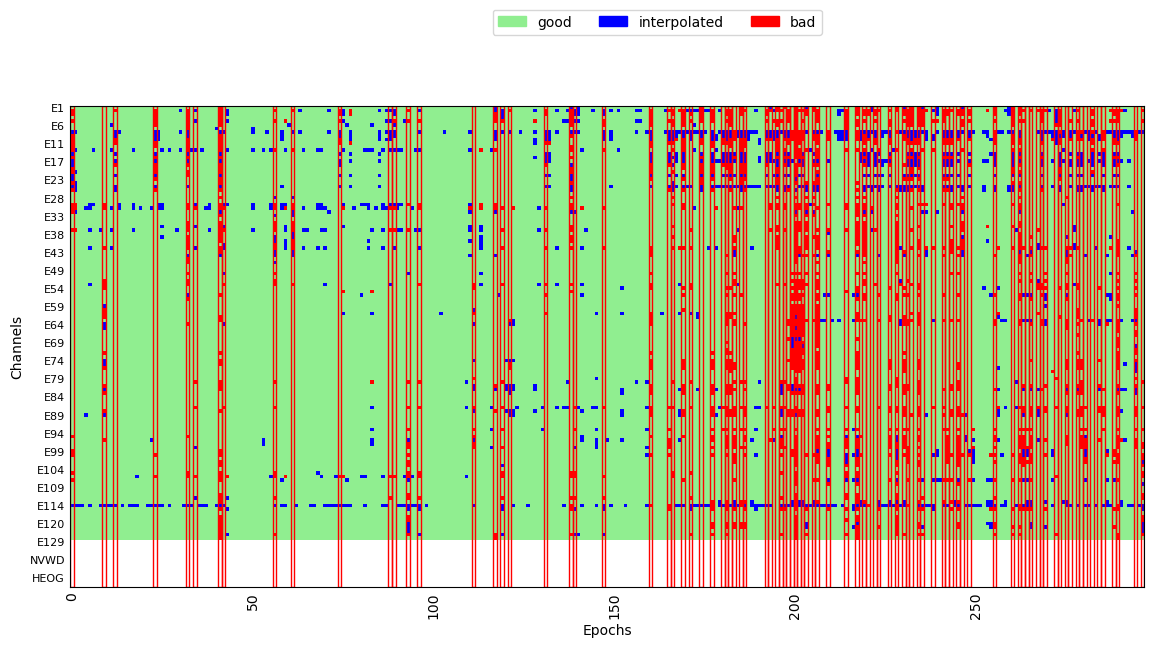

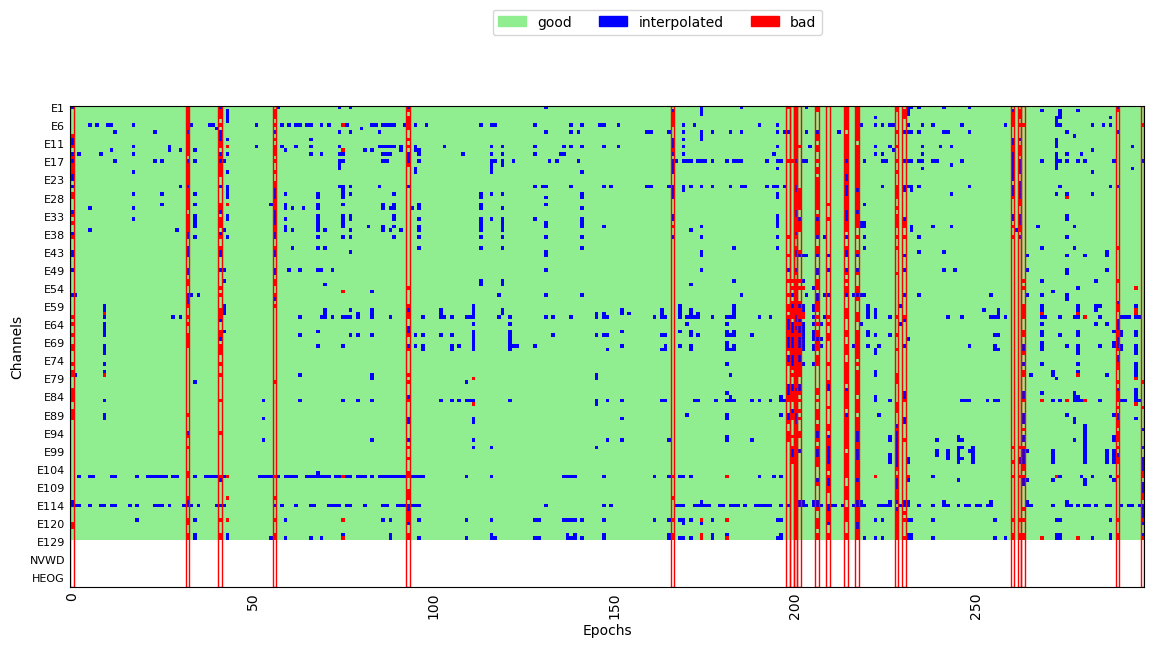

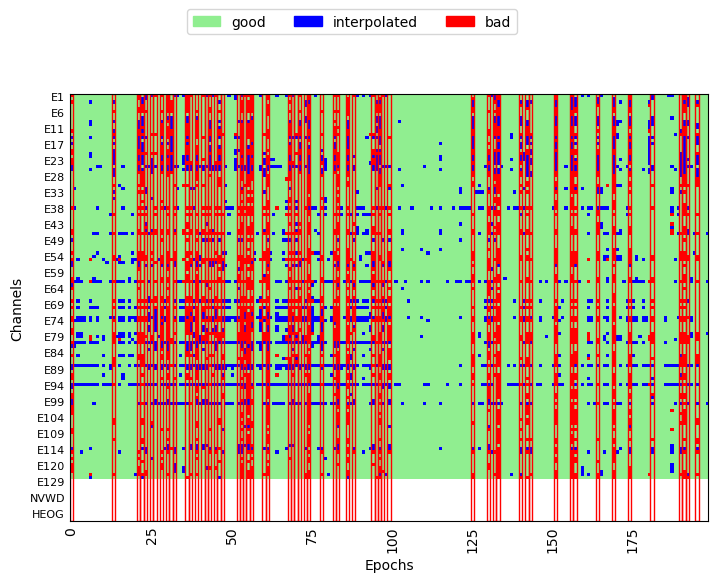

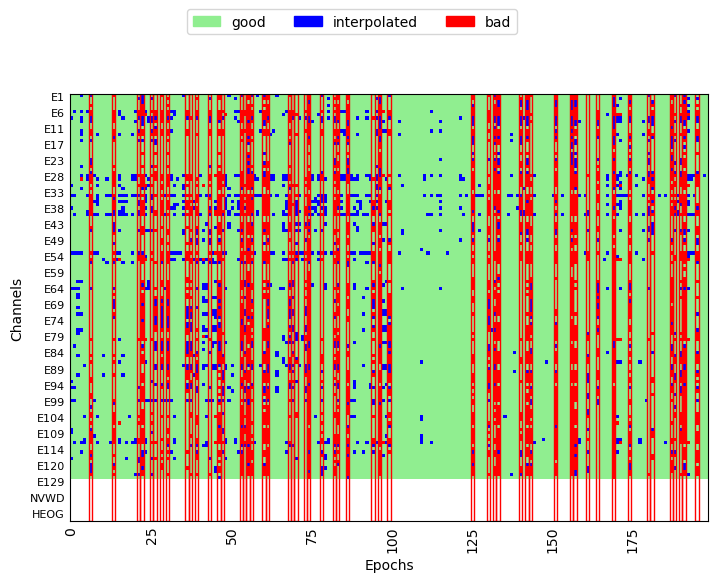

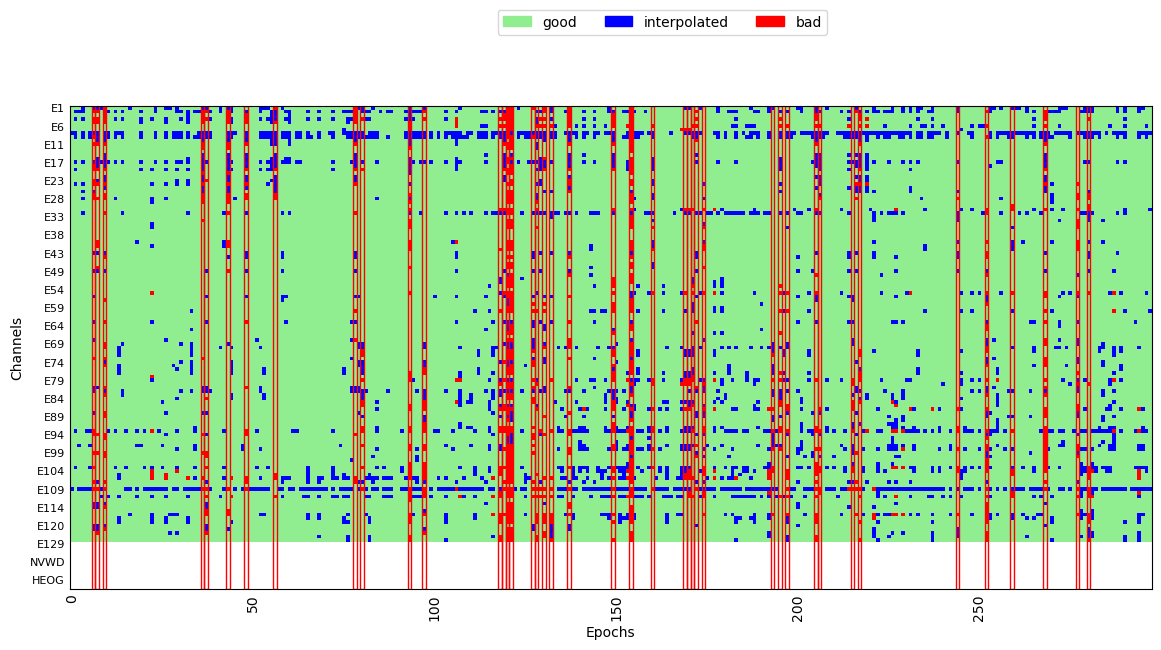

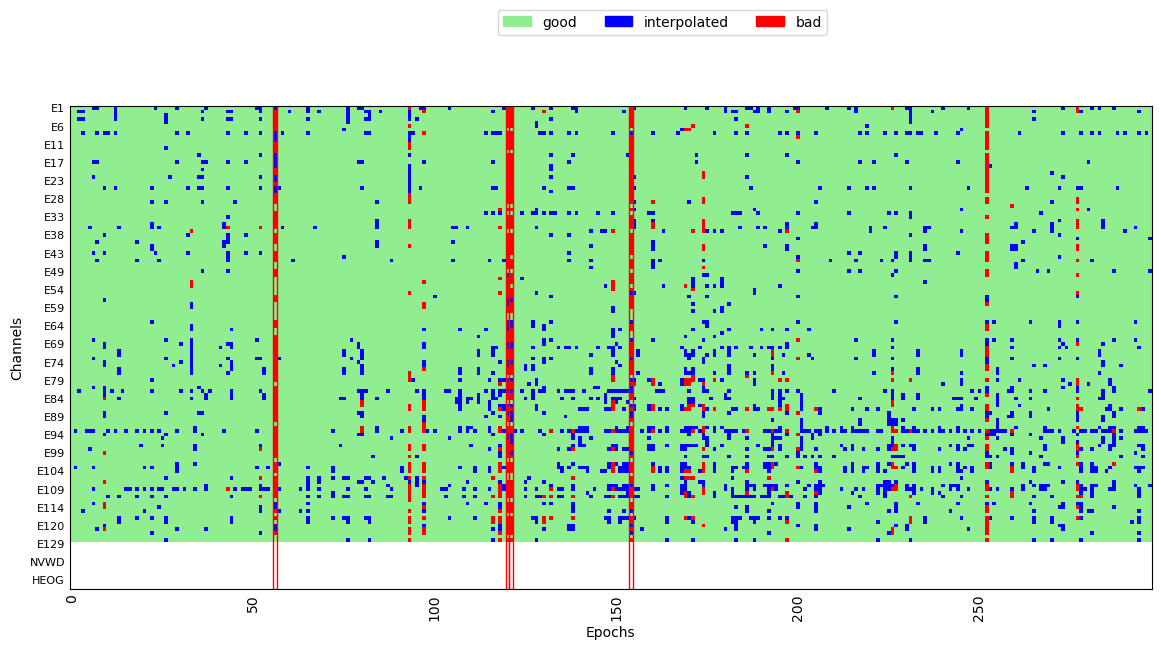

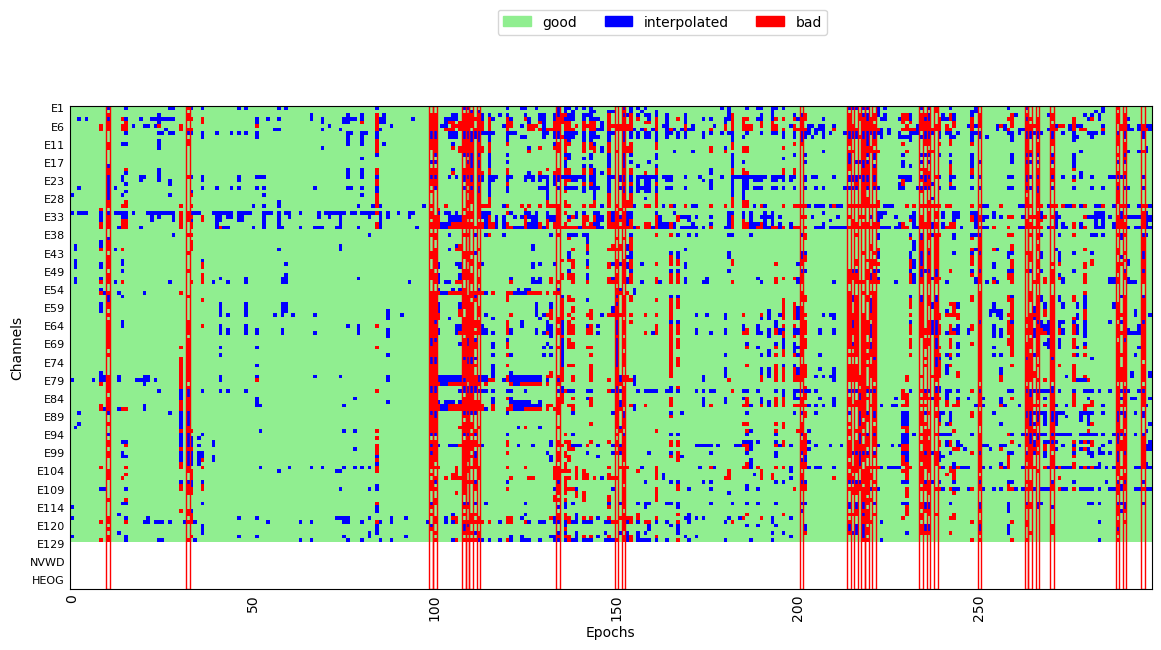

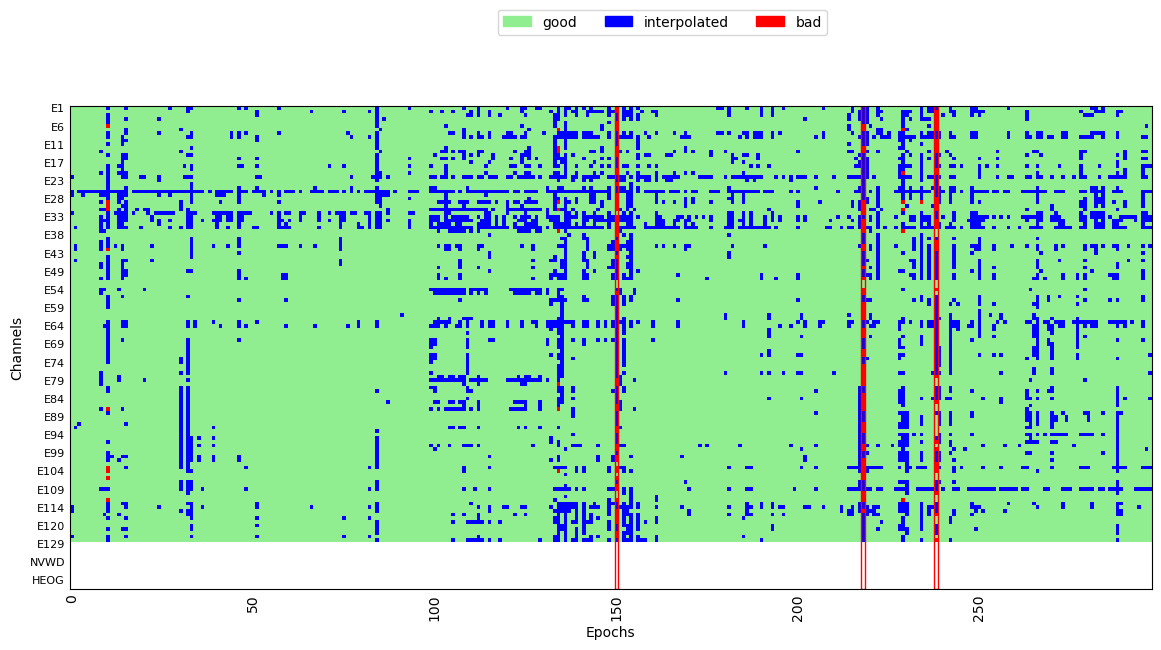

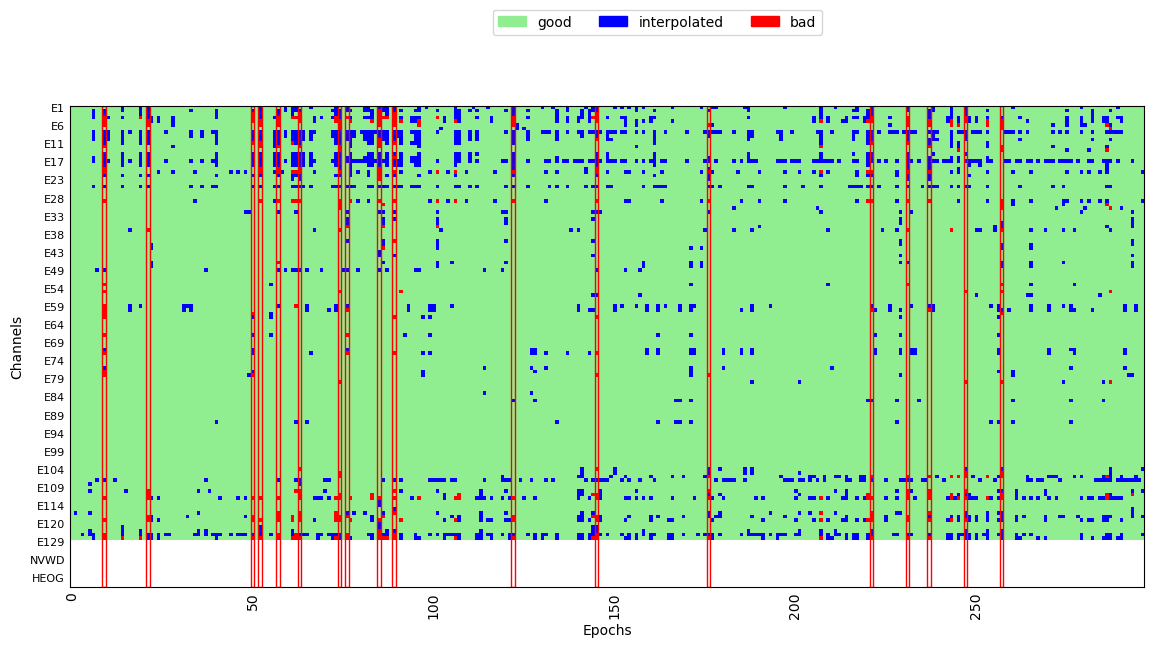

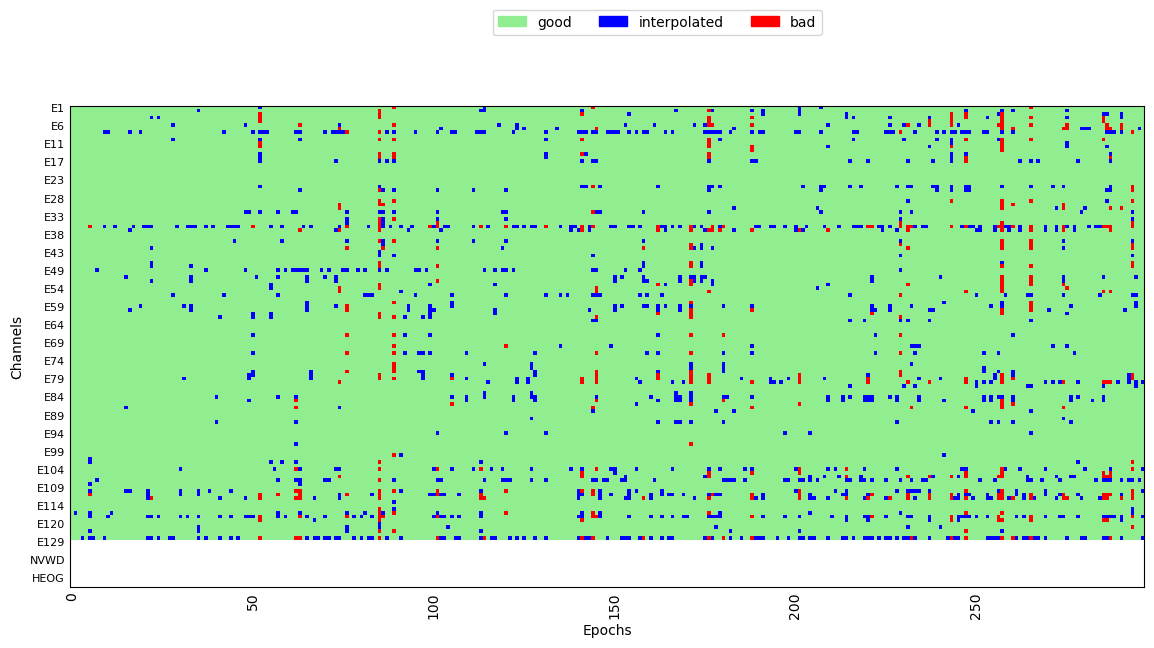

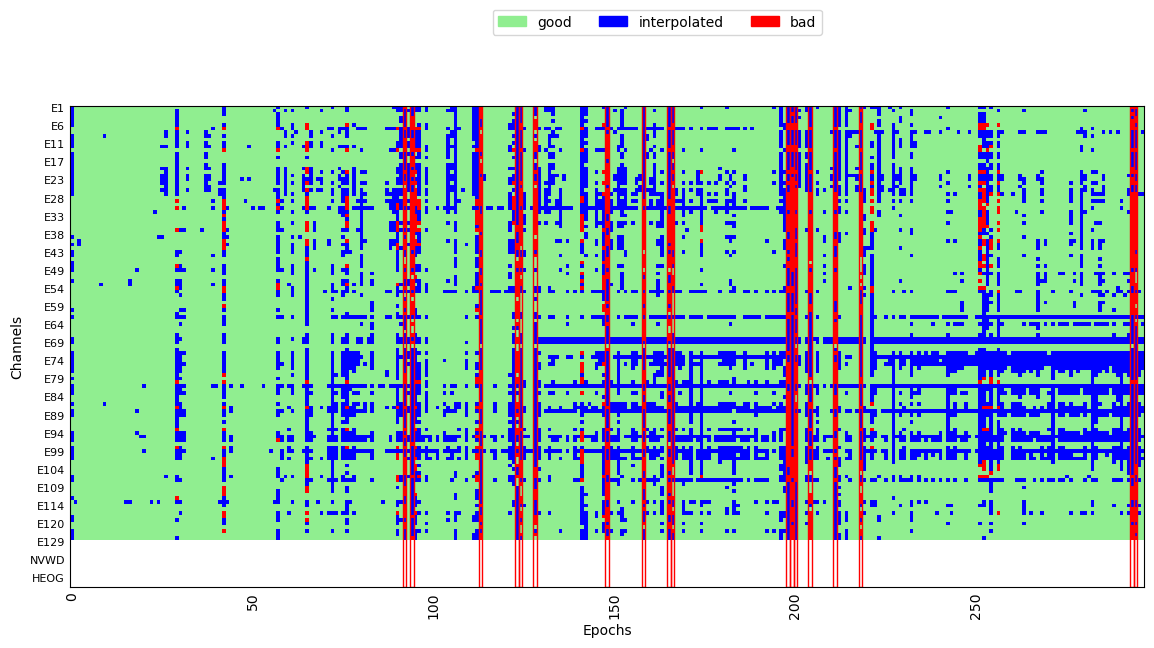

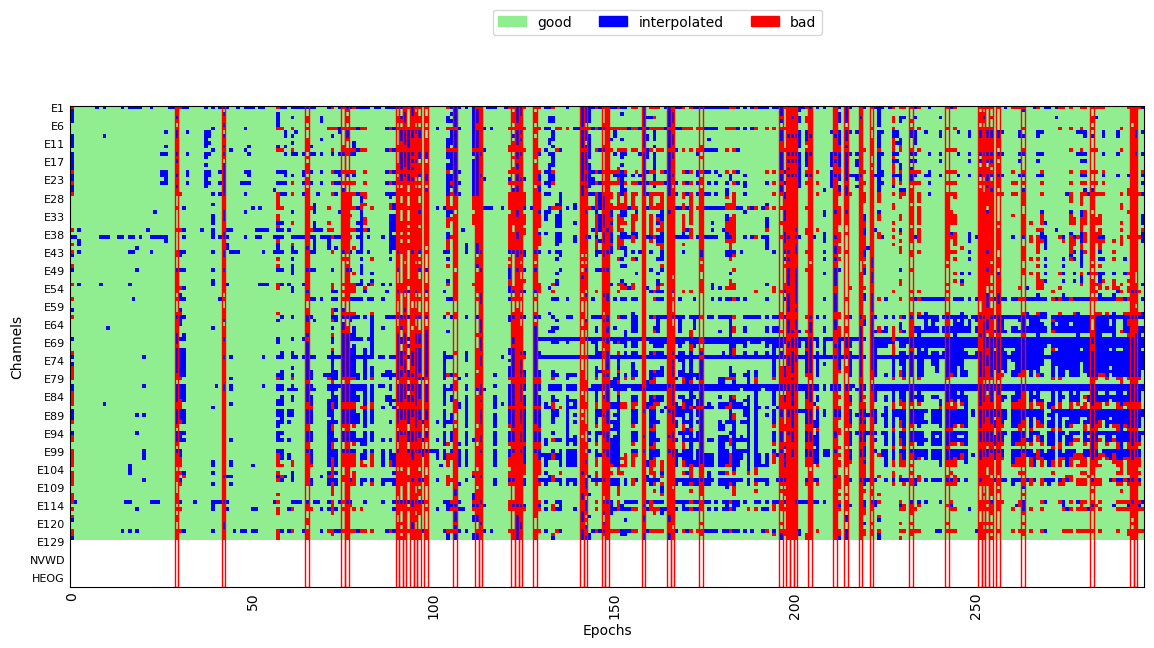

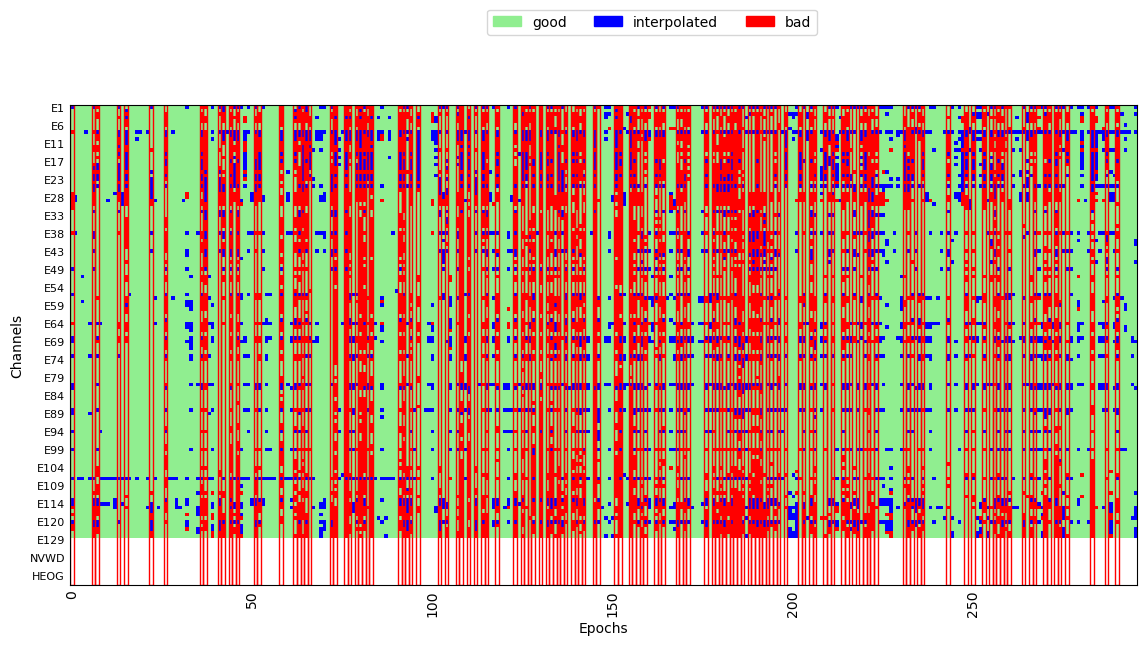

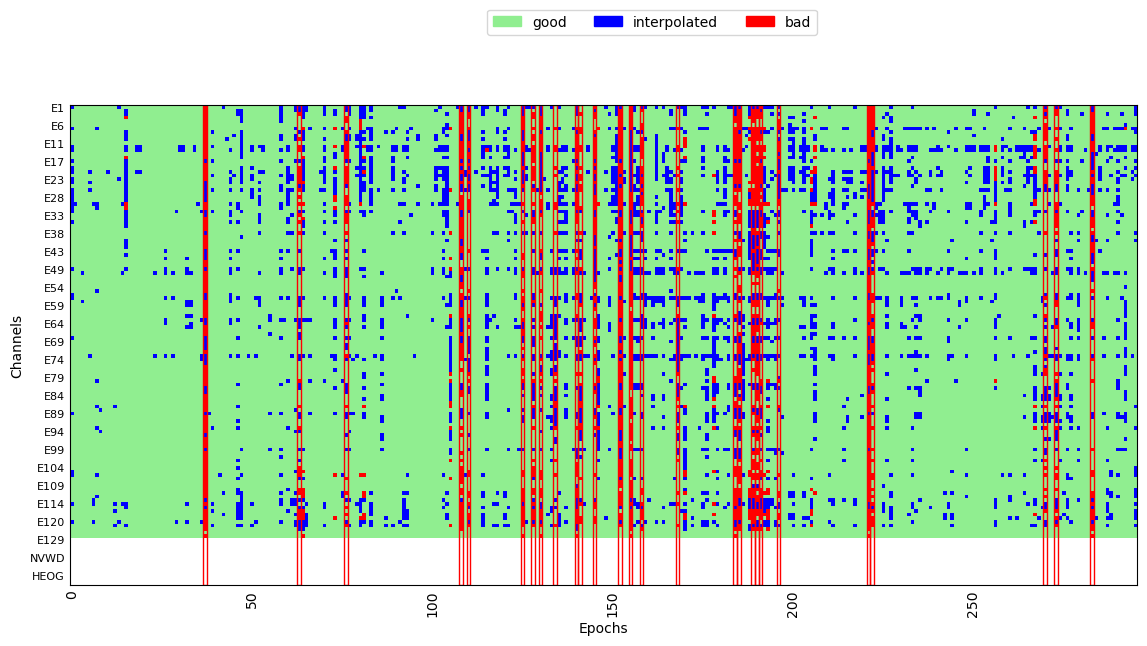

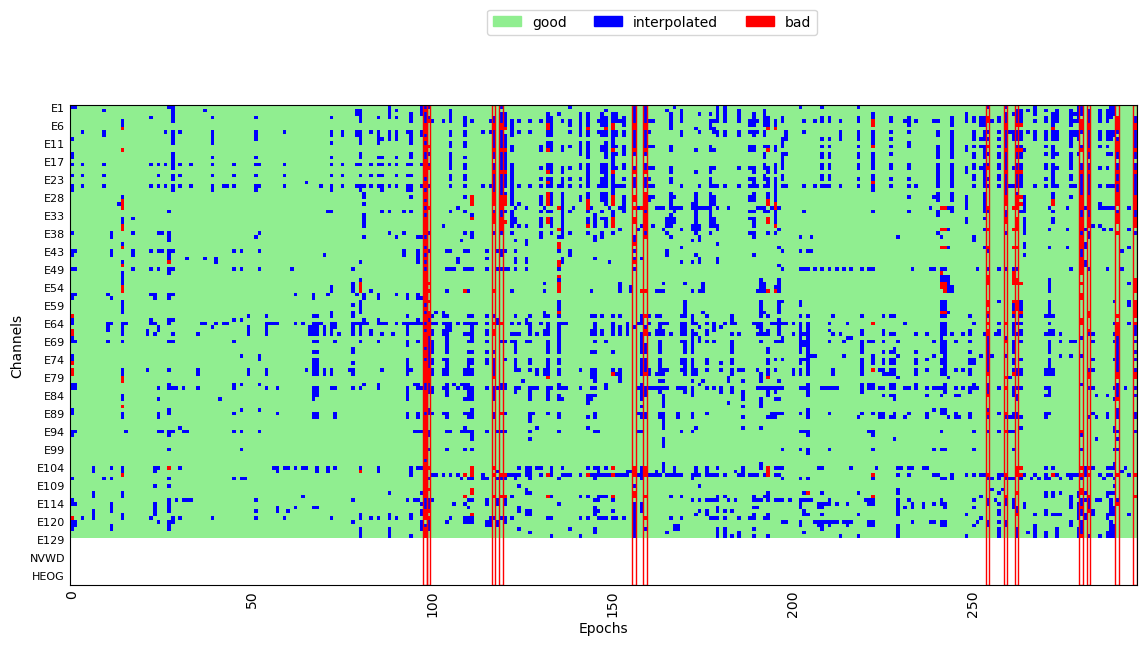

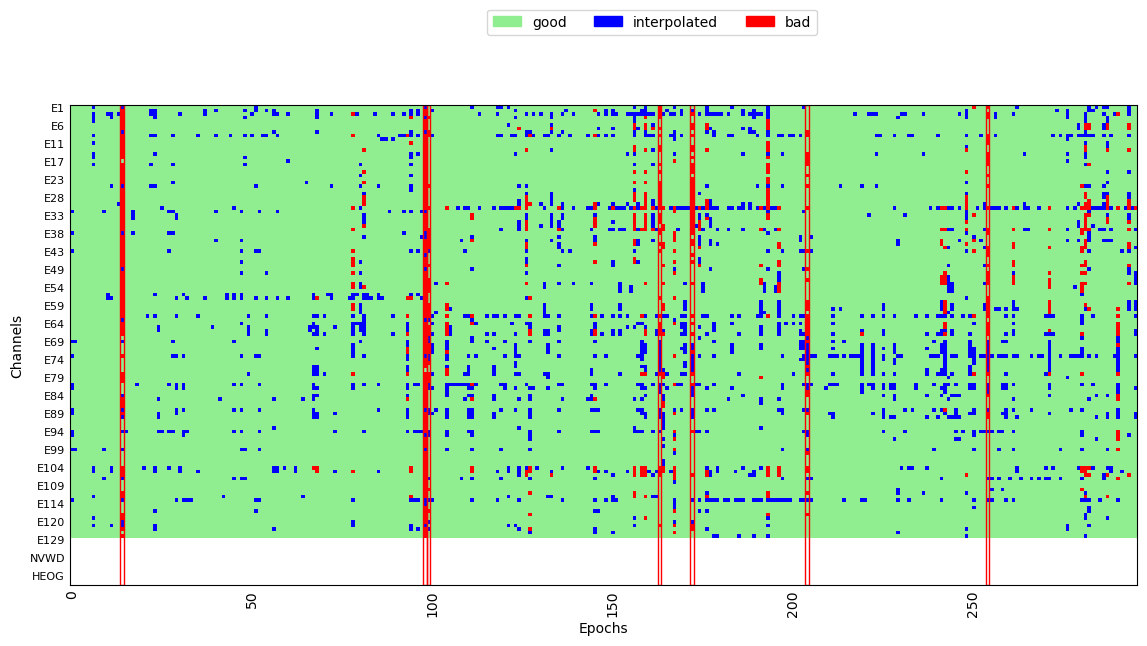

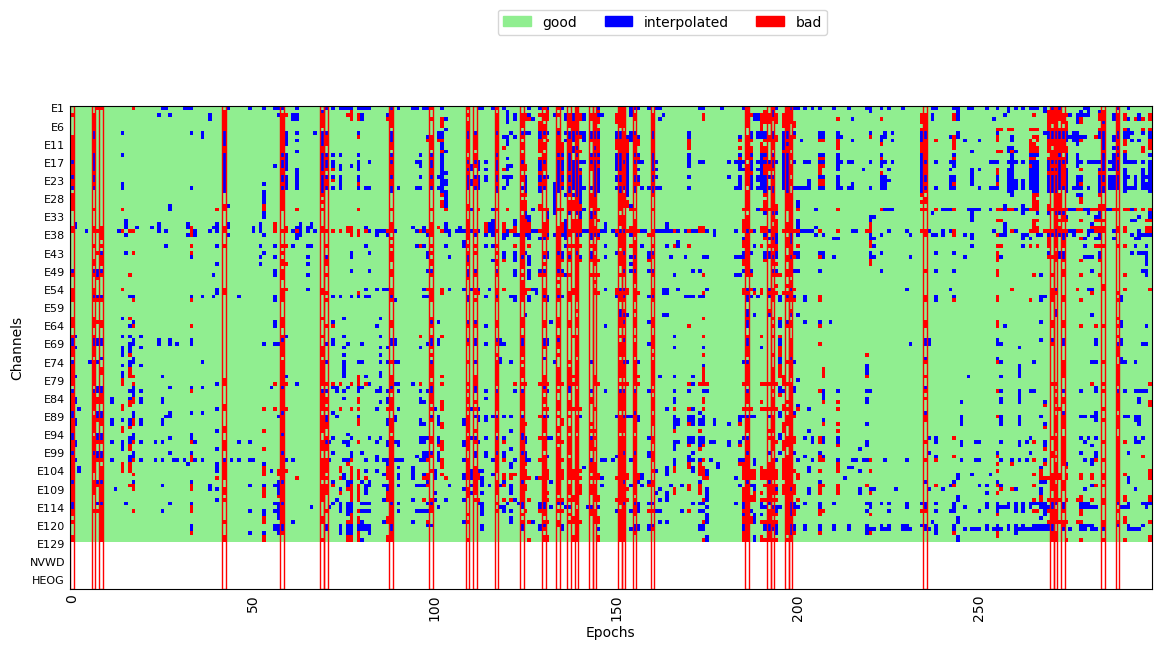

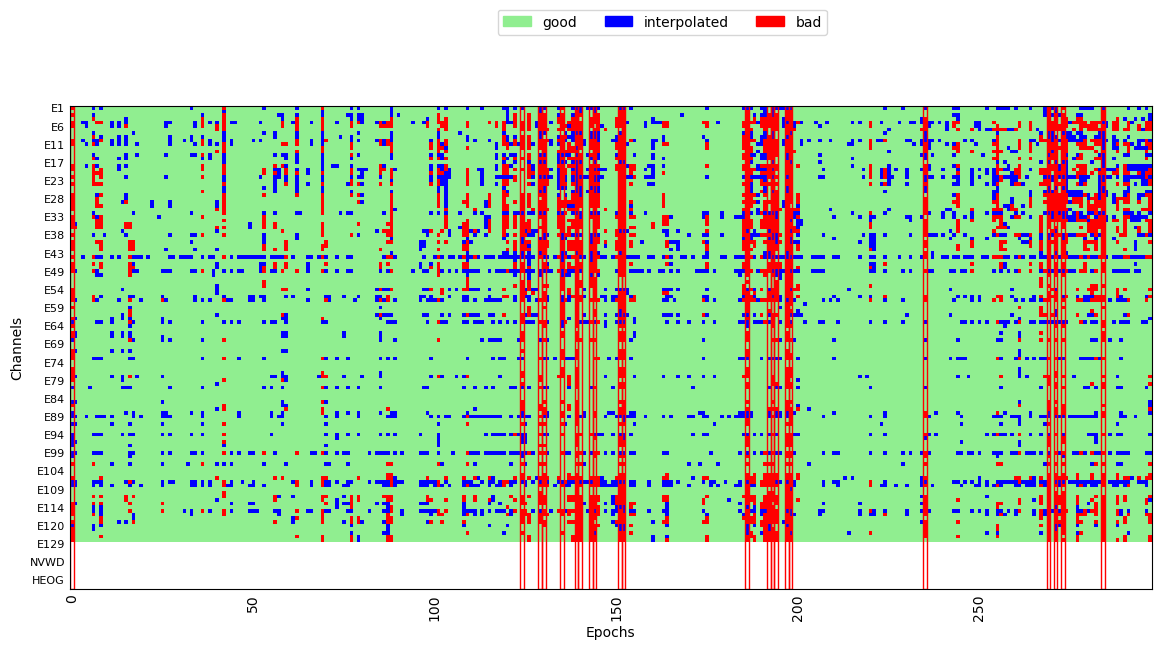

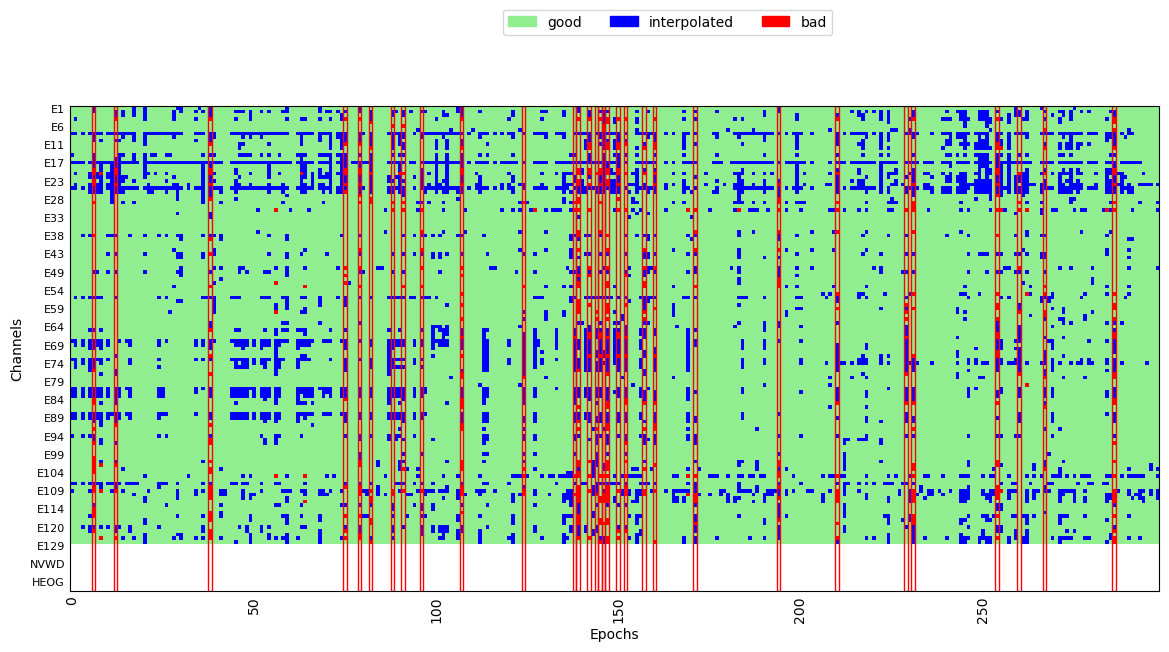

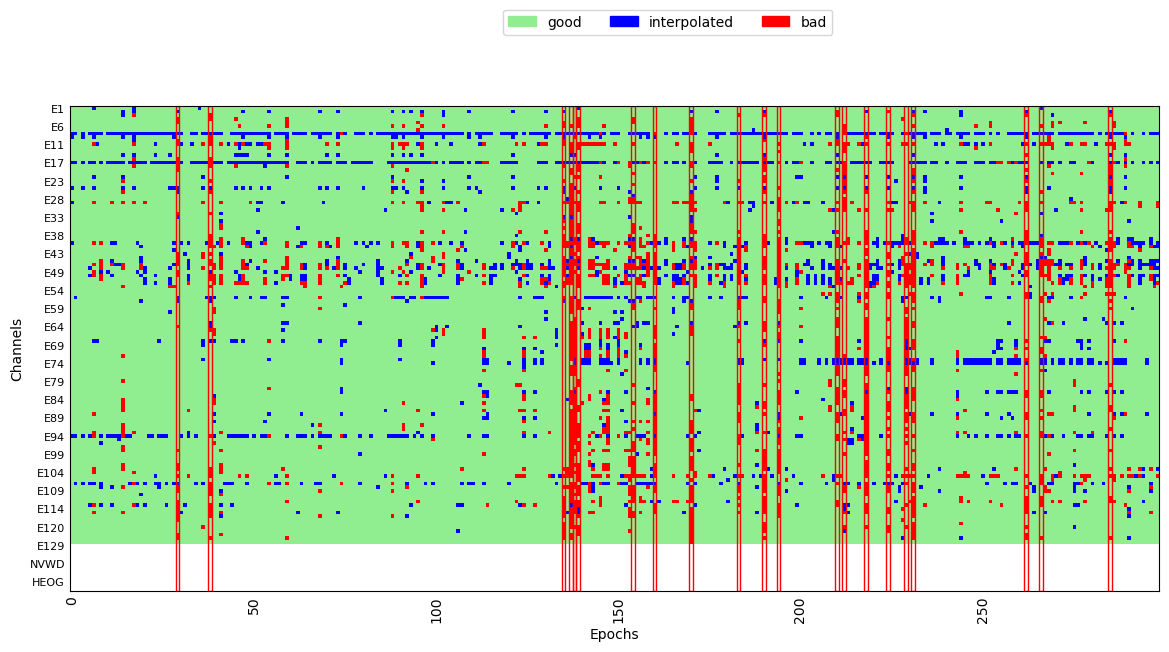

In [6]:
rej_log_list = []

# for testing: most challenging Ss for automated preprocessing:
# subjects = ['sub-002', 'sub-009', 'sub-015', 'sub-016', 'sub-018', 
#             'sub-022', 'sub-023', 'sub-025', 'sub-027', 'sub-030', 'sub-037', 
#             'sub-044', 'sub-045', 'sub-046', 'sub-052', 'sub-053'
#            ]

# subjects = ['sub-045']

for subject in subjects:
    start_time = time()
    print('\n-------------------------')
    print('-------- ' + subject + ' --------')
    print('-------------------------')

    report = mne.Report(subject=subject, 
                        title=study_name + ' preprocessing: ' + subject,
                        verbose='WARNING')

    ### subject-specific paths
    in_path = BIDSPath(root=raw_path, 
                       subject=subject[-3:], 
                       datatype=data_type,
                       task=task
                      )    

    ### Import data
    raw = read_raw_bids(in_path)
    
    # manually-flagged bad channels
    # raw.info['bads'] = bad_ch[subject]
    
    # drop useless channels that mess with topomaps
    raw.drop_channels(drop_ch)

    # Create bipolar EOG channels
    raw = mne.set_bipolar_reference(raw.load_data(), 
                                    anode=[e[0] for e in eog.values()],
                                    cathode=[e[1] for e in eog.values()],
                                    ch_name=list(eog.keys()),
                                    ch_info=[{'kind':202} for i in range(len(eog.keys()))]
                                   )    
    
    ### Filtering
    # channel selection
    picks = mne.pick_types(raw.info, 
                           eeg=True,
                           eog=True
                          )
    
    ## Filter for ICA  
    raw_ica = raw.copy().filter(filt_p['l_freq_ica'], filt_p['h_freq'],
                                picks=picks,
                                n_jobs=n_jobs
                               )

    ## Filter for final
    raw.filter(filt_p['l_freq'], filt_p['h_freq'],
               picks=picks,
               n_jobs=n_jobs
              )
    
    ## Add raw to report
    report.add_raw(raw=raw, 
               psd=True, butterfly=True, 
               title='Raw data, bandpass filtered ' + str(filt_p['l_freq']) + '–' + str(filt_p['h_freq'])
              )

    ### Read events
    events, event_dict = mne.events_from_annotations(raw)

    event_dict_new = {}
    for key, value in event_dict.items():
        if key in event_id.keys():
            # rename events of experimental interest
            event_dict_new[event_id[key]] = value
        # else:
        #     # keep other events to create more epochs for ICA to fit on
        #     event_dict_new[key] = value                       
    
    ## Add events to report
    report.add_events(events, event_id=event_dict_new, 
                      sfreq=raw.info['sfreq'],
                      title='Events'
                     )
    
    ### Epoch data filtered for ICA
    epochs_ica = mne.Epochs(raw_ica,
                            events, event_dict_new,
                            epoch_p['tmin'], epoch_p['tmax'],
                            baseline=epoch_p['baseline'], detrend=epoch_p['detrend'],
                            reject=epoch_p['reject'], 
                            flat=epoch_p['flat'],
                            preload=True
                           )

    
    # use AutoReject to remove bad epochs, repair sensors and return clean epochs.
    ar = AutoReject(n_interpolate=[8, 16, 32, 64, 96],
                    random_state=ica_p['ica_random_state'],
                    picks=mne.pick_types(epochs_ica.info, eeg=True, eog=False),
                    n_jobs=n_jobs, 
                    verbose=False
                   )
    ar.fit(epochs_ica)
    # if subject == 'sub-045':
    #     ar.transform(epochs_ica)
    print('n_interpolate = ' +  str(ar.n_interpolate_['eeg']))
    reject_log = ar.get_reject_log(epochs_ica)
    fig = reject_log.plot('horizontal', show=False);
    report.add_figure(fig=fig, title='AutoReject log')

    ### Fit ICA
    ica = mne.preprocessing.ICA(method='fastica',
                                n_components=ica_p['n_components'],
                                random_state=ica_p['ica_random_state'],
                                max_iter='auto')
    
    ica.fit(epochs_ica[~reject_log.bad_epochs],  # added [~reject_log.bad_epochs] for AutoReject
            decim=3, 
            # reject=reject,  # removed this line as I think it's redundant
            picks=['eeg']
            );

    # Identify ocular ICs
    # The default *z* threshold doesn't work for
    # all subjects. This routine starts with the default z (from config) and steps down
    # until at least n_max_eog EOG components are identified.
    # The limitations of this are that it assumes there will always be at least n_max_eog EOG
    # components (blinks are always present, but horizontal movements are not
    # always present), and may not work if there are > 3 components, if the
    # score of the third is > `z_step` less than the score of the second.
    # In practice, many of these components (with EGI data) may not be ocular, but are (hopefully) not EEG.
    # Be sure to check the reports and confirm no ERP components are rejected!

    ica.exclude = []
    num_excl = 0
    z_thresh = ica_p['ica_zthresh'] 
    z_step = ica_p['ica_zstep']

    while num_excl < ica_p['n_max_eog']:
        eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, threshold=z_thresh)
        num_excl = len(eog_indices)
        z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

    ica.exclude = eog_indices
    z_thresh_final = round(z_thresh + z_step, 2)

    # Manual removal/re-addition of ICs based on visual inspection
    if subject in ica_manual:
        if 'add_ics' in ica_manual[subject]:
            for ic in ica_manual[subject]['add_ics']:
                ica.exclude.append(ic)
        if 'rm_ics' in ica_manual[subject]:
            for ic in ica_manual[subject]['rm_ics']:
                ica.exclude.remove(ic)         

    # Create average of EOG events
    eog_evoked = mne.preprocessing.create_eog_epochs(raw_ica).average().apply_baseline(baseline=(None, epoch_p['tmin']))

    ## Add ICA to report
    report.add_ica(ica=ica, title='ICA', inst=epochs_ica,
                   eog_evoked=eog_evoked, 
                   eog_scores=eog_scores,
                   n_jobs=n_jobs
                  )
    
    ### Segment filtered raw data into epochs for final analysis
    epochs = mne.Epochs(raw,
                        events, event_dict_new,
                        epoch_p['tmin'], epoch_p['tmax'],
                        baseline=epoch_p['baseline'], detrend=epoch_p['detrend'],
                        reject=epoch_p['reject'], 
                        flat=epoch_p['flat'],
                        preload=True
                       )

    ### Apply ICA correction to epochs
    ica.apply(epochs)
    

    ### Apply AutoReject to further clean epochs
    ar = AutoReject(n_interpolate=[8, 16, 32, 64, 96],
                    random_state=ica_p['ica_random_state'],
                    picks=mne.pick_types(epochs_ica.info, eeg=True, eog=False),
                    n_jobs=n_jobs, 
                    verbose=False
                   )
    epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True)
    fig = reject_log.plot('horizontal', show=False)
    report.add_figure(fig=fig, title='AutoReject log')

    ### Re-reference, now that channels are cleaned
    epochs_clean.set_eeg_reference(ref_channels='average');
    
    ### Save cleaned epochs
    out_path = BIDSPath(root=derivatives_path, 
                       subject=subject[-3:], 
                       datatype=data_type,
                       task=task
                      )    
    # remove old fif file if it exists, and update bids_path
    if str(out_path.fpath)[-len(epochs_suffix):] == epochs_suffix:
        remove(out_path.fpath)
        out_path = BIDSPath(root=derivatives_path, 
                   subject=subject[-3:], 
                   datatype=data_type,
                   task=task
                  )    
    # save the file
    epochs_clean.save(str(out_path.fpath) + epochs_suffix, 
                      overwrite=True)

    # add epochs to report
    report.add_epochs(epochs_clean,  
                      title='Epochs'
                     )
    ### Save plot of average across all trials
    fig = epochs_clean.copy().average().plot(spatial_colors=True, 
                                      show=False);
    
    # add figures to report
    report.add_figure(fig=fig, title='Grand average over all epochs')
    plt.close(fig)
    
    # Add plots of average of each condition
    for condition in event_id.values():
        fig = epochs_clean[condition].copy().average().plot(spatial_colors=True, 
                                                            show=False);
        report.add_figure(fig=fig, title=condition)
        plt.close(fig)
    
    proc_time = time() - start_time
    print('Total processing time: ', proc_time)

    ### Report on how much was rejected
    rm_epochs = epochs.selection.shape[0] - epochs_clean.selection.shape[0]
    pct_epochs = rm_epochs / epochs.selection.shape[0] * 100   
    rej_log_list.append(pd.DataFrame({'id':subject, 
                                      'cpu_time':proc_time,
                                      'ntrials_rej':rm_epochs,
                                      '%t_rej':round(pct_epochs, 2),
                                      'ic_rm':len(ica.exclude),
                                      'n_interp':str(ar.n_interpolate_['eeg'])
                                     }, index=[0]
                                    )
                       )

    # Save report to file
    report_name = report_path + '/' + subject + '.html'
    report.save(report_name, overwrite=True)
    
# Collate report logs
rej_log = pd.concat(rej_log_list)
rej_log.to_csv(report_path + '/rejection_log_all_Ss.csv')